Step 1: Data Wringling and Preprocessing 

In [8]:
# Install necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Conv1D, Flatten, Dense, Dropout, Input

In [9]:
# Dataframe for Lyme Disease Cases
df1 = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/LD_Case_Counts_by_County_2022.csv', encoding='ISO-8859-1')

In [10]:
# Dataframes for climatic variables
df_precip = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/climdiv_precip_2001_2022_selectedStates.csv')
df_max_temp = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/climdiv_tmax_2001_2022_selectedStates.csv')
df_min_temp = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/climdiv_tmin_2001_2022_selectedStates.csv')
df_avg_temp = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/climdiv_tmp_2001_2022_selectedStates.csv')

In [11]:
# Data cleaning and getting rid of NaN values
dfs = {
    "Precipitation": df_precip,
    "Max Temperature": df_max_temp,
    "Min Temperature": df_min_temp,
    "Average Temperature": df_avg_temp
}

for name, df in dfs.items():
    print(f"\nChecking {name} DataFrame")
    rows_with_nan = df[df.isna().any(axis=1)]
    if not rows_with_nan.empty:
        print(f"Rows with NaN values in {name} DataFrame:\n", rows_with_nan)
    else:
        print(f"No NaN values found in {name} DataFrame.")
    rows_with_zero = df[(df == 0).any(axis=1)]
    if not rows_with_zero.empty:
        print(f"Rows with 0 values in {name} DataFrame:\n", rows_with_zero)
    else:
        print(f"No 0 values found in {name} DataFrame.")



Checking Precipitation DataFrame
No NaN values found in Precipitation DataFrame.
Rows with 0 values in Precipitation DataFrame:
          Record ID  January  February  March  April   May  June  July  August  \
292     1025012016     3.20      5.35   7.62   4.94  2.57  5.31  7.13    4.58   
407     1035012016     4.63      4.49   6.93   5.87  3.42  4.67  4.57    5.88   
453     1039012016     4.51      4.57   5.53   6.53  2.98  4.38  4.42    4.91   
614     1053012016     4.24      3.94   7.34   6.89  3.33  4.95  4.47    5.44   
1143    1099012016     4.37      4.56   7.35   5.41  3.18  5.54  4.72    5.07   
2845    8091012016     4.70      5.69   6.67   5.98  2.60  5.00  5.53    7.20   
3098    8113012016     3.72      4.52   6.61   5.93  2.40  6.45  5.45    6.97   
3305    8131012016     5.74      5.82   6.95   6.66  2.82  4.64  4.81    8.34   
17807  22037012005     3.55      7.54   5.80   3.95  4.40  3.86  4.74    5.47   
18405  22089012005     3.01      5.34   5.38   6.54  4.09  2

In [12]:
# Displaying column names 
for name, df in dfs.items():
    print(f"\n--- {name} DataFrame Column Headers ---")
    print(df.columns.tolist())


--- Precipitation DataFrame Column Headers ---
['Record ID', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'State Code', 'Year', 'County Code']

--- Max Temperature DataFrame Column Headers ---
['Record ID', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'State FIPS', 'County FIPS', 'Year']

--- Min Temperature DataFrame Column Headers ---
['Record ID', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'State ID', 'County ID', 'Year']

--- Average Temperature DataFrame Column Headers ---
['Record ID', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'State FIPS', 'County FIPS', 'Year']


In [13]:
# Rename columns and merge dataframes
df_precip = df_precip.rename(columns={'State Code': 'State', 'County Code': 'County'})
df_max_temp = df_max_temp.rename(columns={'State FIPS': 'State', 'County FIPS': 'County'})
df_min_temp = df_min_temp.rename(columns={'State ID': 'State', 'County ID': 'County'})
merged_df = df_precip.merge(df_max_temp, on=['State', 'County', 'Year'], how='inner', suffixes=('_precip', '_max_temp'))
merged_df = merged_df.merge(df_min_temp, on=['State', 'County', 'Year'], how='inner', suffixes=('', '_min_temp'))

# Merged datframe
print("Counties that match across all datasets:")
print(merged_df[['State', 'County', 'Year']])
print(f"\nTotal matching records: {len(merged_df)}")

Counties that match across all datasets:
       State  County  Year
0          1    1001  2001
1          1    1001  2002
2          1    1001  2003
3          1    1001  2004
4          1    1001  2005
...      ...     ...   ...
35305     47   47141  2018
35306     47   47141  2019
35307     47   47141  2020
35308     47   47141  2021
35309     47   47141  2022

[35310 rows x 3 columns]

Total matching records: 35310


In [14]:
# Calculate yearly averages, mininmums, maximums, and ranges for all dataframes

df_precip['Precip_avg'] = df_precip[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                     'September', 'October', 'November', 'December']].mean(axis=1)

df_min_temp['Min_temp'] = df_min_temp[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December']].min(axis=1)

df_max_temp['Max_temp'] = df_max_temp[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December']].max(axis=1)

df_max_temp['Temp_range'] = df_max_temp['Max_temp'] - df_min_temp['Min_temp']

df_avg_temp['Avg_temp'] = df_avg_temp[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December']].mean(axis=1)

In [15]:
# Merging dataframes and checking for data consistency by computing pairwise checks

df_precip = df_precip.rename(columns={'State Code': 'State', 'County Code': 'County'})
df_max_temp = df_max_temp.rename(columns={'State FIPS': 'State', 'County FIPS': 'County'})
df_min_temp = df_min_temp.rename(columns={'State ID': 'State', 'County ID': 'County'})
df_avg_temp = df_avg_temp.rename(columns={'State FIPS': 'State', 'County FIPS': 'County'})

merged_all = df_precip.merge(df_max_temp, on=['State', 'County', 'Year'], how='inner', suffixes=('_precip', '_max_temp'))
merged_all = merged_all.merge(df_min_temp, on=['State', 'County', 'Year'], how='inner', suffixes=('', '_min_temp'))
merged_all = merged_all.merge(df_avg_temp, on=['State', 'County', 'Year'], how='inner', suffixes=('', '_avg_temp'))

total_matches_all = len(merged_all)
print(f"Total records that match across all four datasets: {total_matches_all}")

merged_precip_max = df_precip.merge(df_max_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_precip_max = len(merged_precip_max)
print(f"Total records that match between Precipitation and Max Temperature datasets: {total_matches_precip_max}")

merged_precip_min = df_precip.merge(df_min_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_precip_min = len(merged_precip_min)
print(f"Total records that match between Precipitation and Min Temperature datasets: {total_matches_precip_min}")

merged_precip_avg = df_precip.merge(df_avg_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_precip_avg = len(merged_precip_avg)
print(f"Total records that match between Precipitation and Average Temperature datasets: {total_matches_precip_avg}")

merged_max_min = df_max_temp.merge(df_min_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_max_min = len(merged_max_min)
print(f"Total records that match between Max Temperature and Min Temperature datasets: {total_matches_max_min}")

merged_max_avg = df_max_temp.merge(df_avg_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_max_avg = len(merged_max_avg)
print(f"Total records that match between Max Temperature and Average Temperature datasets: {total_matches_max_avg}")

merged_min_avg = df_min_temp.merge(df_avg_temp, on=['State', 'County', 'Year'], how='inner')
total_matches_min_avg = len(merged_min_avg)
print(f"Total records that match between Min Temperature and Average Temperature datasets: {total_matches_min_avg}")

Total records that match across all four datasets: 35310
Total records that match between Precipitation and Max Temperature datasets: 36915
Total records that match between Precipitation and Min Temperature datasets: 35310
Total records that match between Precipitation and Average Temperature datasets: 36915
Total records that match between Max Temperature and Min Temperature datasets: 35310
Total records that match between Max Temperature and Average Temperature datasets: 36915
Total records that match between Min Temperature and Average Temperature datasets: 35310


In [16]:
# Calculating number of individual counties
print("Unique counties in Precipitation:", df_precip['County'].nunique())
print("Unique counties in Max Temperature:", df_max_temp['County'].nunique())
print("Unique counties in Min Temperature:", df_min_temp['County'].nunique())
print("Unique counties in Average Temperature:", df_avg_temp['County'].nunique())


Unique counties in Precipitation: 1605
Unique counties in Max Temperature: 1605
Unique counties in Min Temperature: 1605
Unique counties in Average Temperature: 1605


In [18]:
# Merging all four climatic variable dataframes into one and eliminating monthly columns
columns_to_keep = [
    'Record ID_precip', 'State', 'Year', 'County', 'Precip_avg', 
    'Record ID_max_temp', 'Max_temp', 'Temp_range', 
    'Record ID', 'Min_temp', 'Record ID_avg_temp', 'Avg_temp'
]
merged_all_cleaned = merged_all[columns_to_keep]
print(merged_all_cleaned)

unique_states = merged_all_cleaned['State'].unique()
print("Unique values in the 'State' column:")
print(unique_states)


       Record ID_precip  State  Year  County  Precip_avg  Record ID_max_temp  \
0            1001012001      1  2001    1001    5.020833          1001272001   
1            1001012002      1  2002    1001    4.278333          1001272002   
2            1001012003      1  2003    1001    5.545000          1001272003   
3            1001012004      1  2004    1001    4.273333          1001272004   
4            1001012005      1  2005    1001    4.860833          1001272005   
...                 ...    ...   ...     ...         ...                 ...   
35305       47141012018     47  2018   47141    3.018333         47141272018   
35306       47141012019     47  2019   47141    3.760000         47141272019   
35307       47141012020     47  2020   47141    2.752500         47141272020   
35308       47141012021     47  2021   47141    3.088333         47141272021   
35309       47141012022     47  2022   47141    2.722500         47141272022   

       Max_temp  Temp_range     Record 

In [19]:
# Re-map NOAA codes to state codes to prepare for merging of the lyme disease case dataframe 
state_fips_mapping = {
    1: 1,    # Alabama
    6: 9,    # Connecticut
    7: 10,   # Delaware
    8: 12,   # Florida
    9: 13,   # Georgia
    11: 17,  # Illinois
    12: 18,  # Indiana
    15: 21,  # Kentucky
    17: 23,  # Maine
    18: 24,  # Maryland
    19: 25,  # Massachusetts
    20: 26,  # Michigan
    22: 28,  # Mississippi
    27: 33,  # New Hampshire
    28: 34,  # New Jersey
    30: 36,  # New York
    31: 37,  # North Carolina
    33: 39,  # Ohio
    36: 42,  # Pennsylvania
    37: 44,  # Rhode Island
    38: 45,  # South Carolina
    40: 47,  # Tennessee
    43: 50,  # Vermont
    44: 51,  # Virginia
    46: 54,  # West Virginia
    47: 55   # Wisconsin
}

# Eliminate data frome states not in the mapping (territories and non-lower 48 states)
merged_all_cleaned = merged_all_cleaned[merged_all_cleaned['State'].isin(state_fips_mapping.keys())]
merged_all_cleaned['State'] = merged_all_cleaned['State'].map(state_fips_mapping)

print(merged_all_cleaned.head())
unique_states = merged_all_cleaned['State'].unique()
print("Unique values in the 'State' column:")
print(unique_states)

   Record ID_precip  State  Year  County  Precip_avg  Record ID_max_temp  \
0        1001012001      1  2001    1001    5.020833          1001272001   
1        1001012002      1  2002    1001    4.278333          1001272002   
2        1001012003      1  2003    1001    5.545000          1001272003   
3        1001012004      1  2004    1001    4.273333          1001272004   
4        1001012005      1  2005    1001    4.860833          1001272005   

   Max_temp  Temp_range     Record ID  Min_temp  Record ID_avg_temp   Avg_temp  
0      90.7        57.0  1.001282e+09      30.7          1001022001  63.758333  
1      91.8        62.6  1.001282e+09      33.7          1001022002  64.350000  
2      89.1        55.3  1.001282e+09      29.2          1001022003  63.483333  
3      90.4        58.6  1.001282e+09      33.8          1001022004  64.300000  
4      89.8        54.2  1.001282e+09      31.8          1001022005  64.025000  
Unique values in the 'State' column:
[ 1  9 10 12 13 17 1

In [20]:
# Load the FIPS county file to match county codes and alphabetic names
county_fips_df = pd.read_csv('/Users/seaniredell/Desktop/Data  for SSCI 575 Project/national_county.txt', 
                             header=None, 
                             names=['state_abbr', 'state_fips', 'county_fips', 'county_name', 'extra'])

# Strip county codes of state codes without leading 0's
county_fips_df['state_fips'] = county_fips_df['state_fips'].apply(lambda x: str(x).zfill(2))
county_fips_df['county_fips'] = county_fips_df['county_fips'].apply(lambda x: str(x)[-3:].zfill(3))
merged_all_cleaned['State'] = merged_all_cleaned['State'].apply(lambda x: str(x).zfill(2))
merged_all_cleaned['County'] = merged_all_cleaned['County'].apply(lambda x: str(x)[-3:].zfill(3))

# Merge the dataframes using the 'State' and 'County' columns as keys
merged_all_cleaned = merged_all_cleaned.merge(
    county_fips_df[['state_fips', 'county_fips', 'county_name']], 
    how='left', 
    left_on=['State', 'County'], 
    right_on=['state_fips', 'county_fips']
)

# Rename 'county_name' column to 'County Name' for clarity
merged_all_cleaned = merged_all_cleaned.rename(columns={'county_name': 'County Name'})
merged_all_cleaned = merged_all_cleaned.drop(columns=['state_fips', 'county_fips'])
print(merged_all_cleaned.head())

   Record ID_precip State  Year County  Precip_avg  Record ID_max_temp  \
0        1001012001    01  2001    001    5.020833          1001272001   
1        1001012002    01  2002    001    4.278333          1001272002   
2        1001012003    01  2003    001    5.545000          1001272003   
3        1001012004    01  2004    001    4.273333          1001272004   
4        1001012005    01  2005    001    4.860833          1001272005   

   Max_temp  Temp_range     Record ID  Min_temp  Record ID_avg_temp  \
0      90.7        57.0  1.001282e+09      30.7          1001022001   
1      91.8        62.6  1.001282e+09      33.7          1001022002   
2      89.1        55.3  1.001282e+09      29.2          1001022003   
3      90.4        58.6  1.001282e+09      33.8          1001022004   
4      89.8        54.2  1.001282e+09      31.8          1001022005   

    Avg_temp     County Name  
0  63.758333  Autauga County  
1  64.350000  Autauga County  
2  63.483333  Autauga County  
3  6

In [21]:
# Export the merged DataFrame to a CSV file
merged_all_cleaned.to_csv('/Users/seaniredell/Desktop/output.csv', index=False)

In [24]:
# Reshape filtered_df to long format so that lyme disease cases will be the same format with yearly averages as climatic variables
filtered_long = pd.melt(
   df1,
    id_vars=['Ctyname', 'stname', 'ststatus', 'stcode', 'ctycode'],
    value_vars=[col for col in df1.columns if col.startswith('Cases')],
    var_name='Year',
    value_name='Cases'
)

# Extract year from the 'Year' column (e.g., 'Cases2001' -> '2001')
filtered_long['Year'] = filtered_long['Year'].str.extract('(\d{4})').astype(int)


In [25]:
filtered_long = filtered_long.rename(columns={'Ctyname': 'County Name'})
print(filtered_long)
print(merged_all_cleaned)

             County Name   stname       ststatus  stcode  ctycode  Year  Cases
0         Autauga County  Alabama  Low Incidence       1        1  2001    0.0
1         Baldwin County  Alabama  Low Incidence       1        3  2001    0.0
2         Barbour County  Alabama  Low Incidence       1        5  2001    0.0
3            Bibb County  Alabama  Low Incidence       1        7  2001    0.0
4          Blount County  Alabama  Low Incidence       1        9  2001    0.0
...                  ...      ...            ...     ...      ...   ...    ...
62875  Sweetwater County  Wyoming  Low Incidence      56       37  2020    0.0
62876       Teton County  Wyoming  Low Incidence      56       39  2020    0.0
62877       Uinta County  Wyoming  Low Incidence      56       41  2020    0.0
62878    Washakie County  Wyoming  Low Incidence      56       43  2020    0.0
62879      Weston County  Wyoming  Low Incidence      56       45  2020    0.0

[62880 rows x 7 columns]
       Record ID_precip St

In [26]:
# Merge climatic variables and lyme disease cases
merged_data = pd.merge(
    filtered_long,  
    merged_all_cleaned[['County Name', 'Year', 'Precip_avg', 'Max_temp', 'Temp_range', 'Avg_temp']],  
    on=['County Name', 'Year'],  # Merge on 'County Name' and 'Year'
    how='left' 
)

print(merged_data.head())
unique_states = merged_data['stname'].unique()
print("Unique values in the 'State' column:")
print(unique_states)
merged_data.shape

      County Name   stname       ststatus  stcode  ctycode  Year  Cases  \
0  Autauga County  Alabama  Low Incidence       1        1  2001    0.0   
1  Baldwin County  Alabama  Low Incidence       1        3  2001    0.0   
2  Baldwin County  Alabama  Low Incidence       1        3  2001    0.0   
3  Barbour County  Alabama  Low Incidence       1        5  2001    0.0   
4  Barbour County  Alabama  Low Incidence       1        5  2001    0.0   

   Precip_avg  Max_temp  Temp_range   Avg_temp  
0    5.020833      90.7        57.0  63.758333  
1    4.674167      89.9        55.4  66.983333  
2    3.585000      90.1        53.4  63.583333  
3    3.879167      90.5        56.5  64.600000  
4    3.741667      81.4        67.6  51.725000  
Unique values in the 'State' column:
['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Main

(188600, 11)

Step 2: Exploratory Data Analysis

In [27]:
# Group by year
grouped_data = merged_data.groupby('Year')[['Cases', 'Precip_avg', 'Max_temp', 'Temp_range', 'Avg_temp']].mean()

# Calculate the correlation matrix 
correlation_matrix = grouped_data.corr()
print(correlation_matrix)


               Cases  Precip_avg  Max_temp  Temp_range  Avg_temp
Cases       1.000000    0.244063 -0.106330   -0.056392  0.094296
Precip_avg  0.244063    1.000000 -0.420706   -0.387340 -0.223486
Max_temp   -0.106330   -0.420706  1.000000    0.995606  0.690531
Temp_range -0.056392   -0.387340  0.995606    1.000000  0.700437
Avg_temp    0.094296   -0.223486  0.690531    0.700437  1.000000


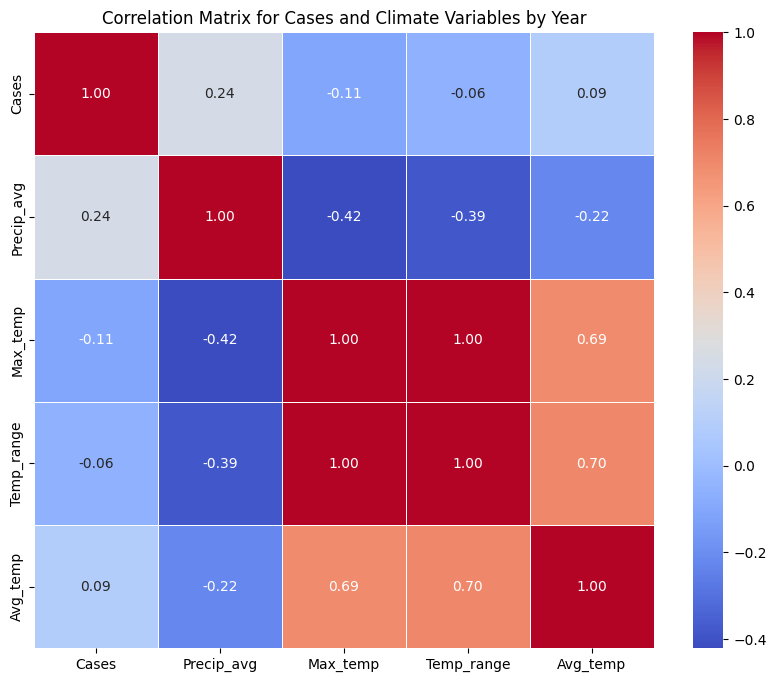

In [28]:
# Group the data by 'Year'
grouped_data = merged_data.groupby('Year')[['Cases', 'Precip_avg', 'Max_temp', 'Temp_range', 'Avg_temp']].mean()

# Create a correlation matrix
correlation_matrix = grouped_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Cases and Climate Variables by Year')
plt.show()

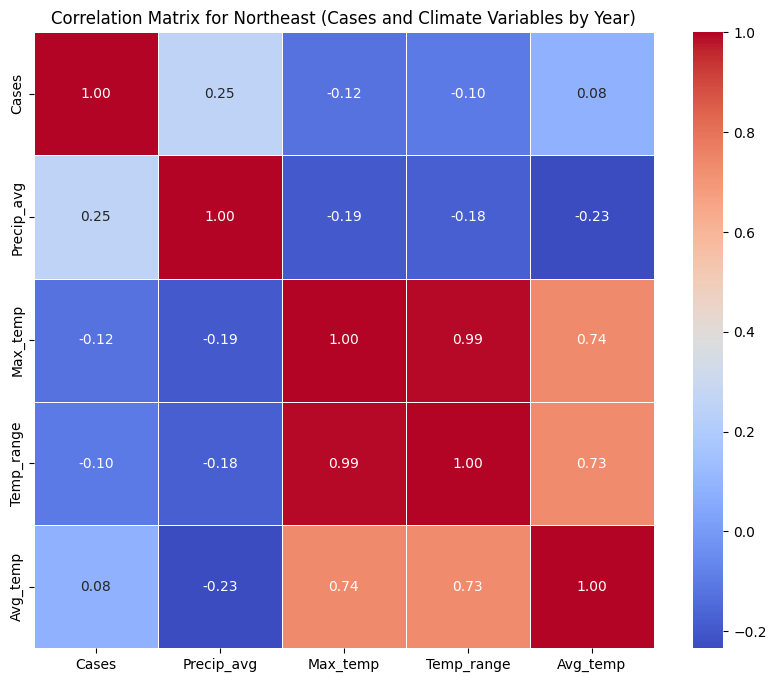

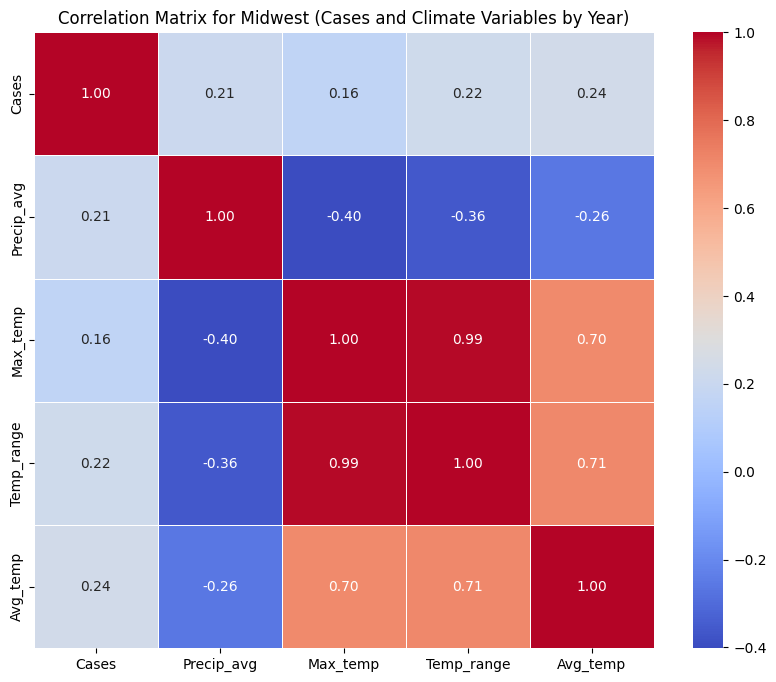

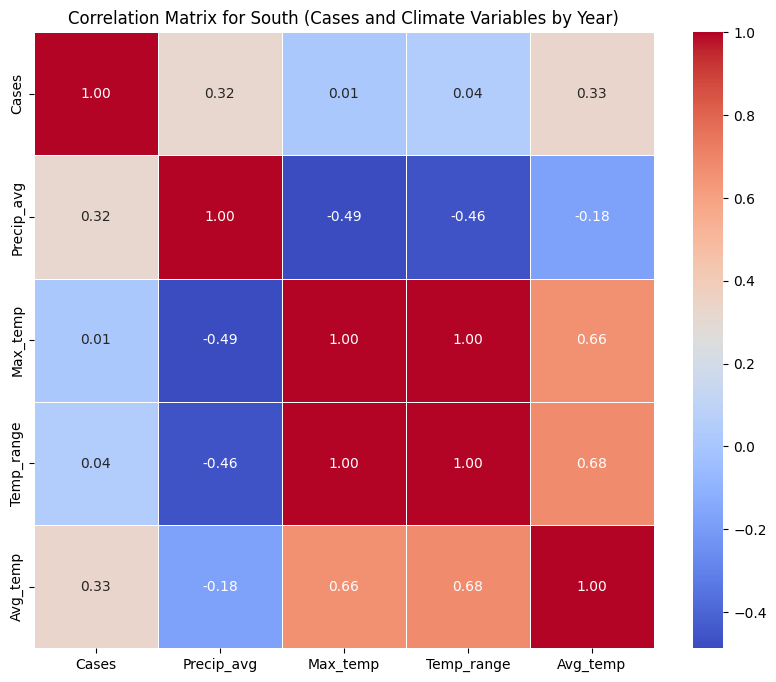

In [29]:
# Define the regions
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Jersey', 'Delaware', 'Maryland', 'New York', 'Pennsylvania'],
    'Midwest': ['Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Missouri', 'Minnesota', 'Iowa', 'Kansas', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Mississippi', 'Alabama', 'Kentucky', 'Tennessee', 'Georgia', 'Florida', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

def assign_region(state):
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'
    
merged_data['Region'] = merged_data['stname'].apply(assign_region)
grouped_data = merged_data.groupby(['Region', 'Year'])[['Cases', 'Precip_avg', 'Max_temp', 'Temp_range', 'Avg_temp']].mean()
grouped_data = grouped_data.reset_index()

# Create a correlation matrix for each region and plot
for region in regions.keys():
    region_data = grouped_data[grouped_data['Region'] == region]
    correlation_matrix = region_data[['Cases', 'Precip_avg', 'Max_temp', 'Temp_range', 'Avg_temp']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'Correlation Matrix for {region} (Cases and Climate Variables by Year)')
    plt.show()



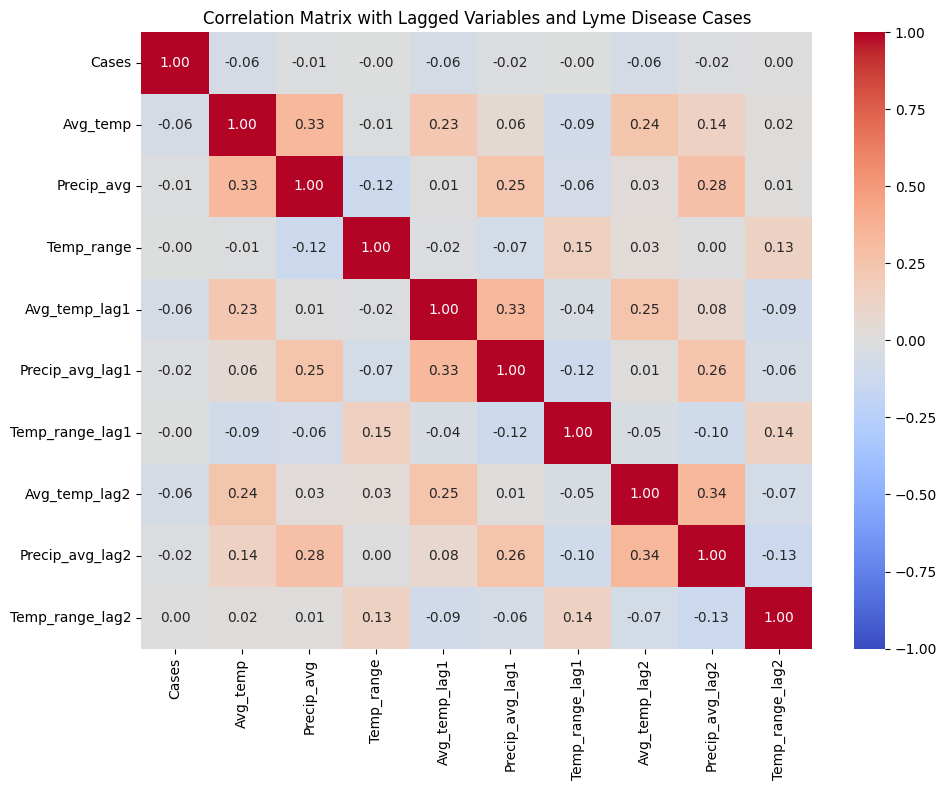

In [30]:
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')

# Create lagged variables for the previous 1 year and 2 years
merged_data['Avg_temp_lag1'] = merged_data.groupby('County Name')['Avg_temp'].shift(1)
merged_data['Precip_avg_lag1'] = merged_data.groupby('County Name')['Precip_avg'].shift(1)
merged_data['Temp_range_lag1'] = merged_data.groupby('County Name')['Temp_range'].shift(1)

merged_data['Avg_temp_lag2'] = merged_data.groupby('County Name')['Avg_temp'].shift(2)
merged_data['Precip_avg_lag2'] = merged_data.groupby('County Name')['Precip_avg'].shift(2)
merged_data['Temp_range_lag2'] = merged_data.groupby('County Name')['Temp_range'].shift(2)

# Drop rows with missing values due to lagging (for any county-year combination that has no lagged data)
merged_data = merged_data.dropna()

# Calculate correlation with Lyme disease cases
correlation_data = merged_data[['Cases', 'Avg_temp', 'Precip_avg', 'Temp_range', 
                                 'Avg_temp_lag1', 'Precip_avg_lag1', 'Temp_range_lag1',
                                 'Avg_temp_lag2', 'Precip_avg_lag2', 'Temp_range_lag2']]

correlation_matrix = correlation_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Matrix with Lagged Variables and Lyme Disease Cases")
plt.tight_layout()  # Ensure everything fits well
plt.show()



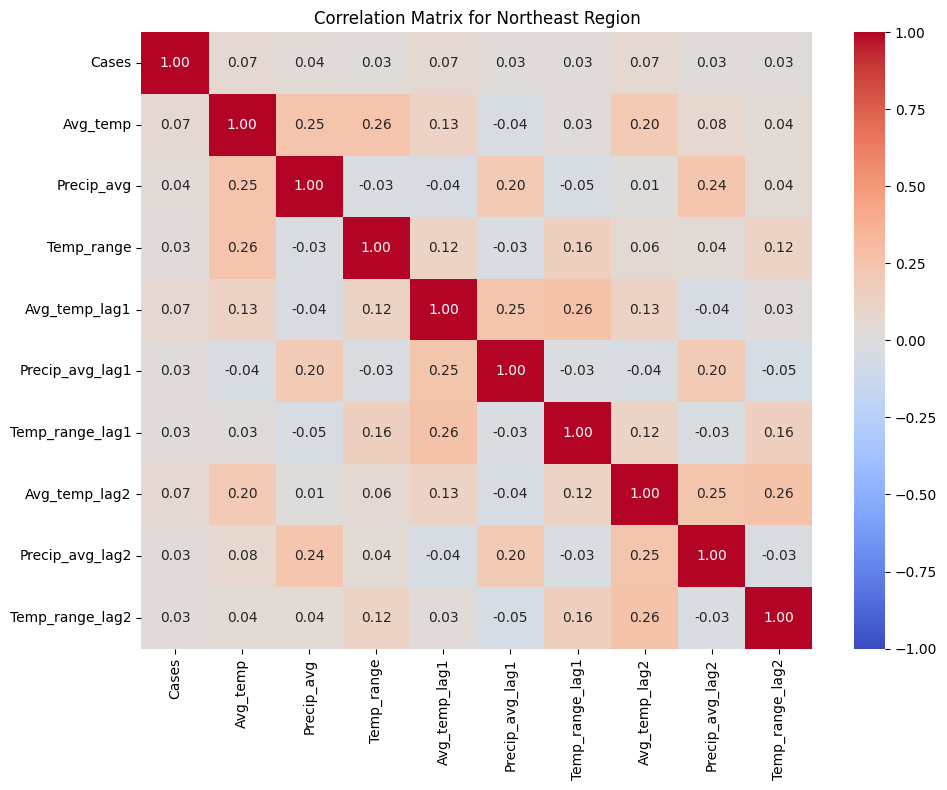

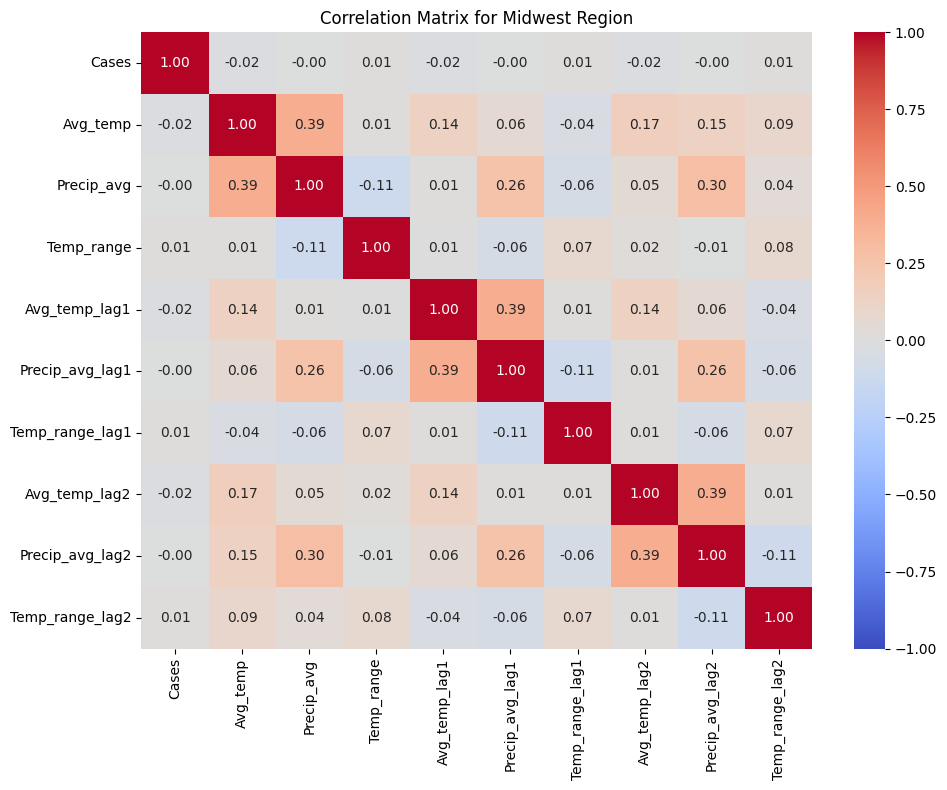

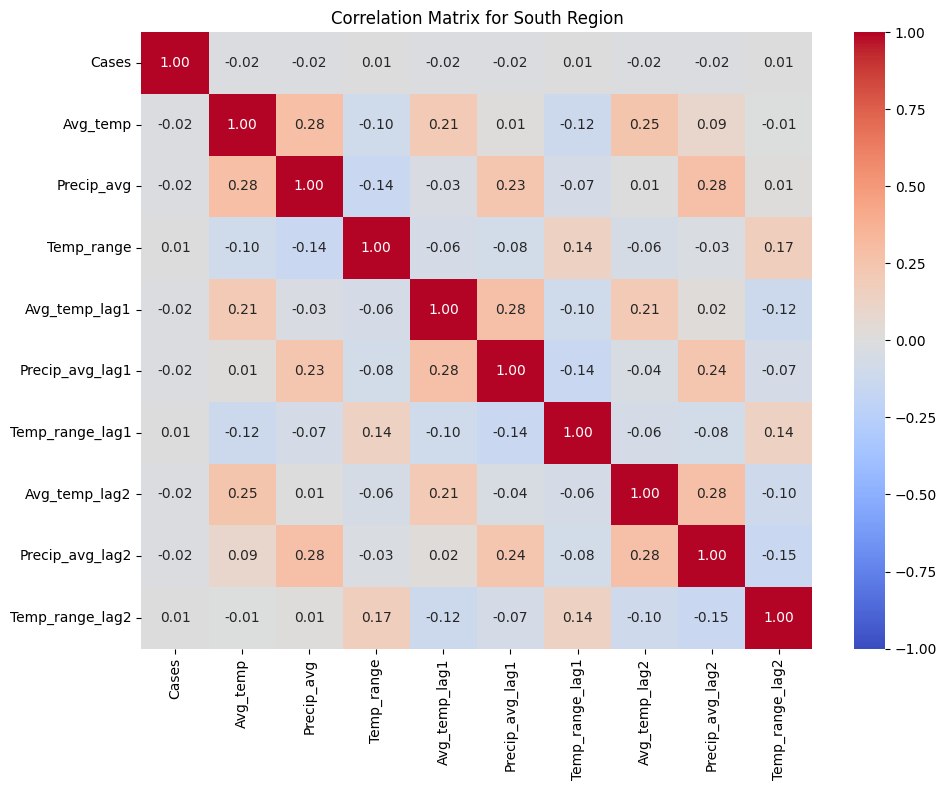

In [31]:
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')

# Define regions
regions = {
    'Northeast': ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Jersey', 'Delaware', 'Maryland', 'New York', 'Pennsylvania'],
    'Midwest': ['Wisconsin', 'Illinois', 'Indiana', 'Michigan', 'Ohio', 'Missouri', 'Minnesota', 'Iowa', 'Kansas', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Mississippi', 'Alabama', 'Kentucky', 'Tennessee', 'Georgia', 'Florida', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia']
}

# Try lagged variables for 1 year and 2 years
merged_data['Avg_temp_lag1'] = merged_data.groupby('County Name')['Avg_temp'].shift(1)
merged_data['Precip_avg_lag1'] = merged_data.groupby('County Name')['Precip_avg'].shift(1)
merged_data['Temp_range_lag1'] = merged_data.groupby('County Name')['Temp_range'].shift(1)

merged_data['Avg_temp_lag2'] = merged_data.groupby('County Name')['Avg_temp'].shift(2)
merged_data['Precip_avg_lag2'] = merged_data.groupby('County Name')['Precip_avg'].shift(2)
merged_data['Temp_range_lag2'] = merged_data.groupby('County Name')['Temp_range'].shift(2)
merged_data = merged_data.dropna()

for region_name, states in regions.items():
    region_data = merged_data[merged_data['stname'].isin(states)]
    correlation_data = region_data[['Cases', 'Avg_temp', 'Precip_avg', 'Temp_range', 
                                     'Avg_temp_lag1', 'Precip_avg_lag1', 'Temp_range_lag1',
                                     'Avg_temp_lag2', 'Precip_avg_lag2', 'Temp_range_lag2']]
    correlation_matrix = correlation_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for {region_name} Region")
    plt.tight_layout()
    plt.show()


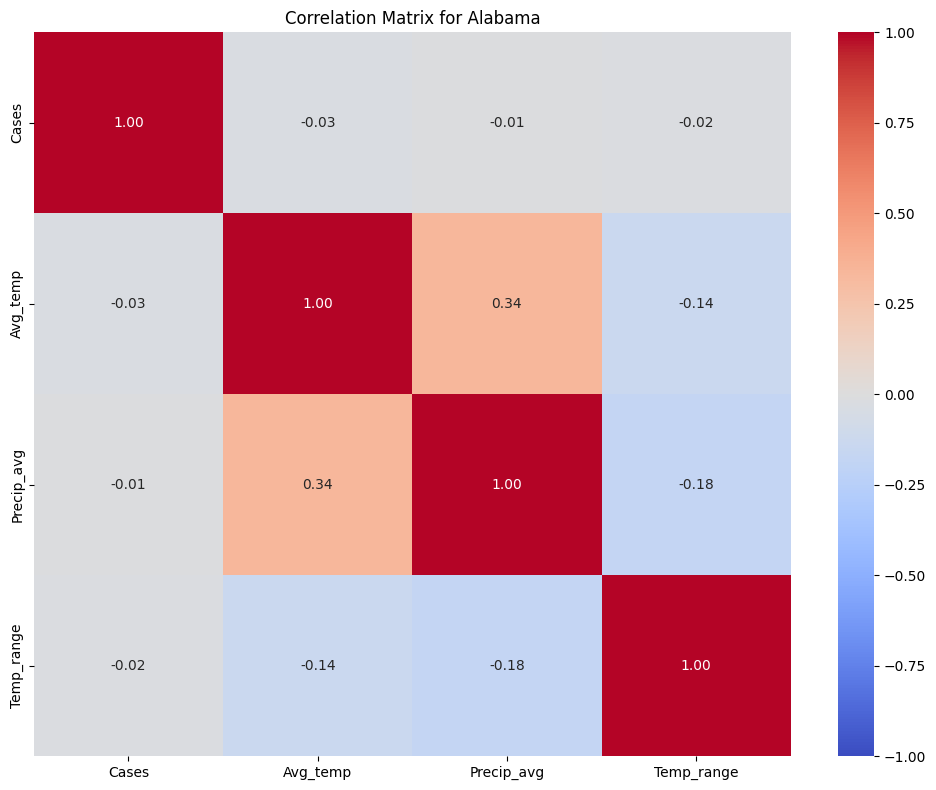

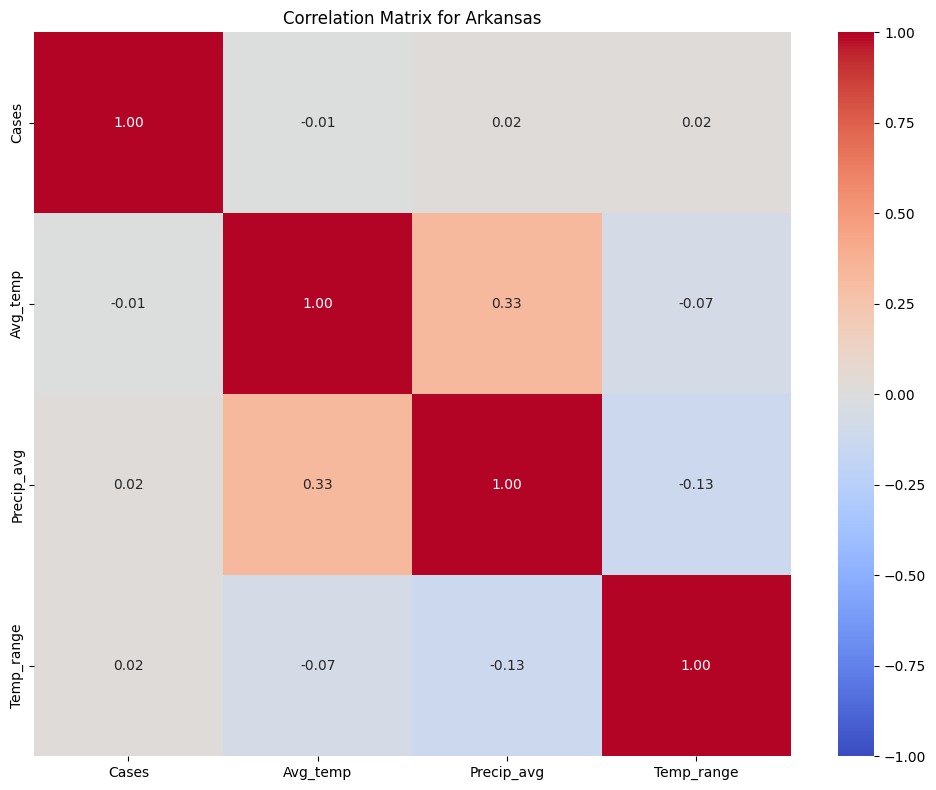

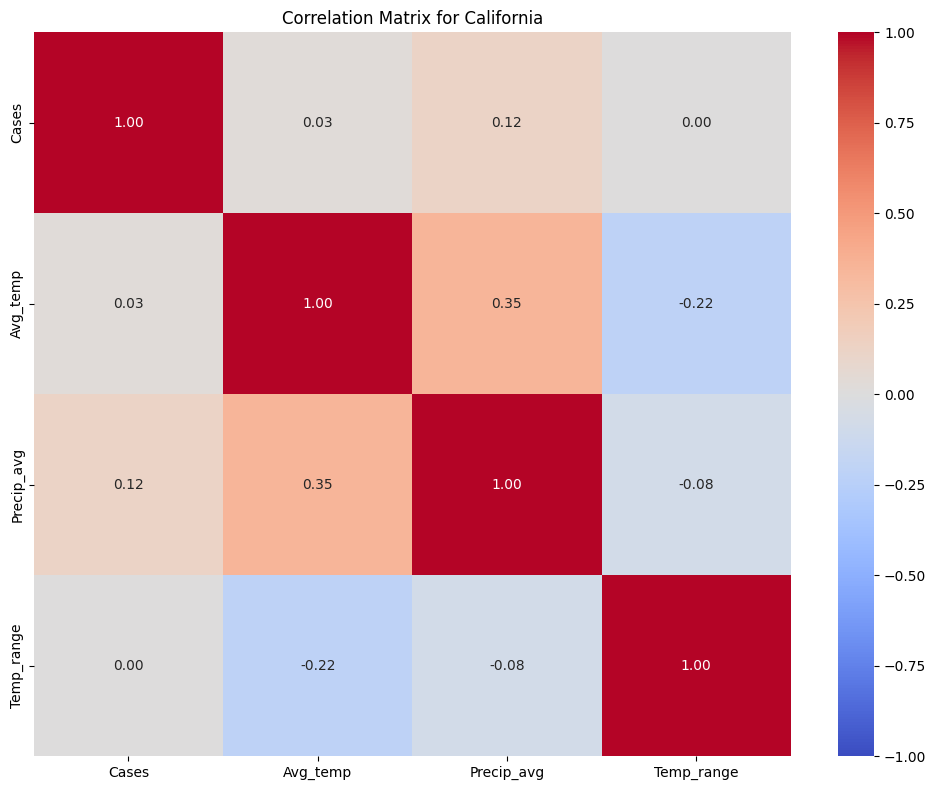

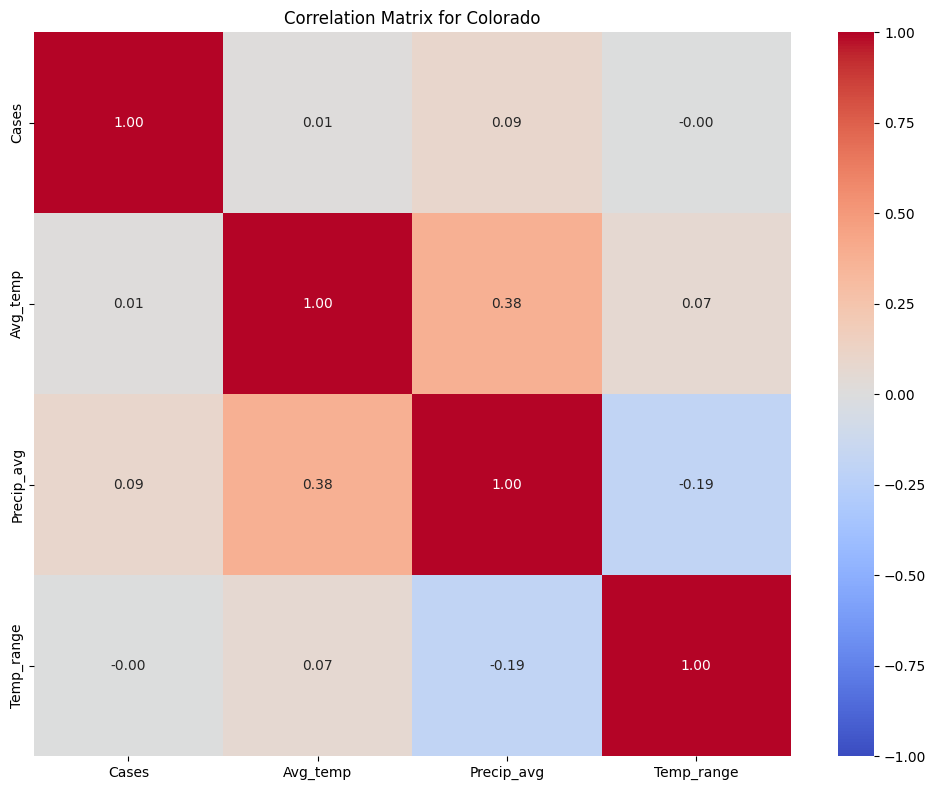

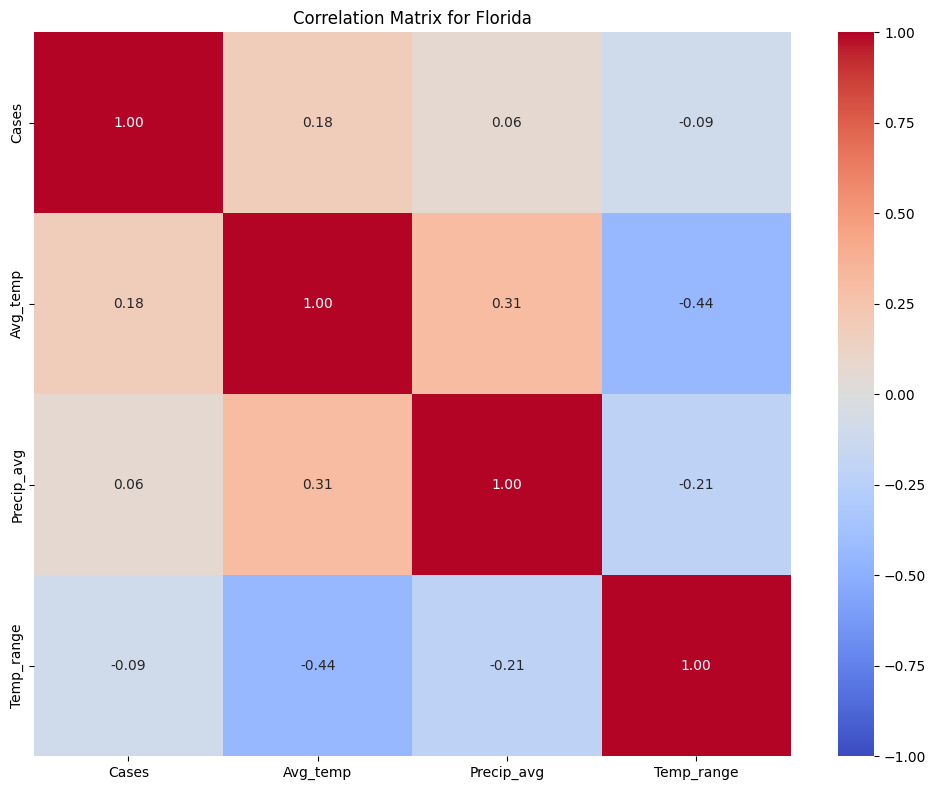

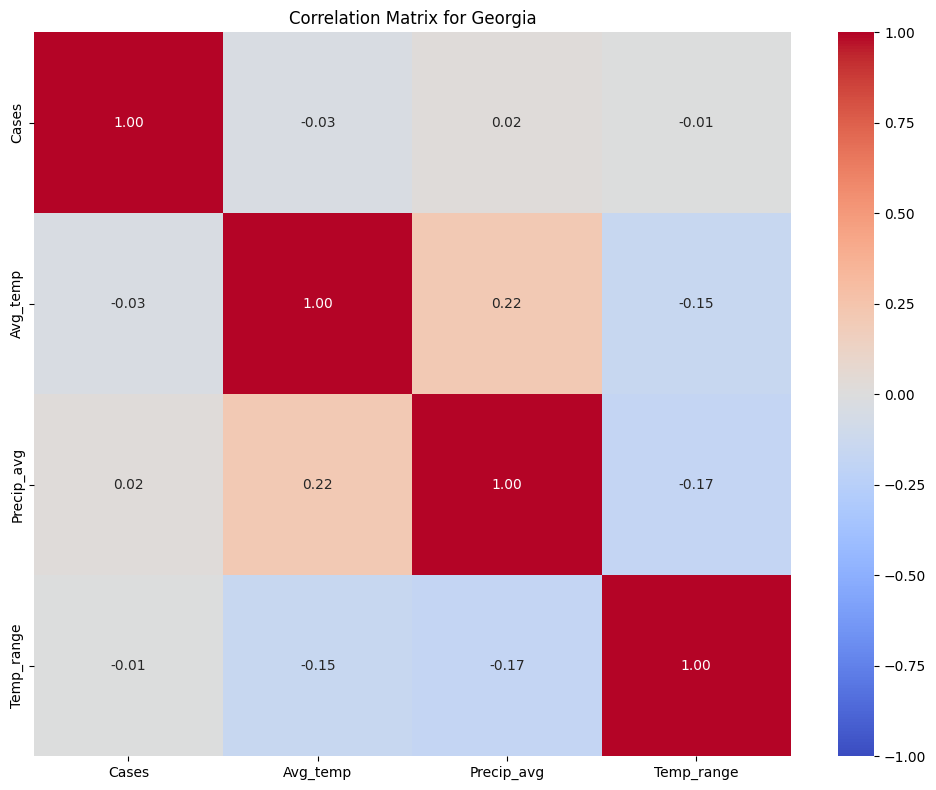

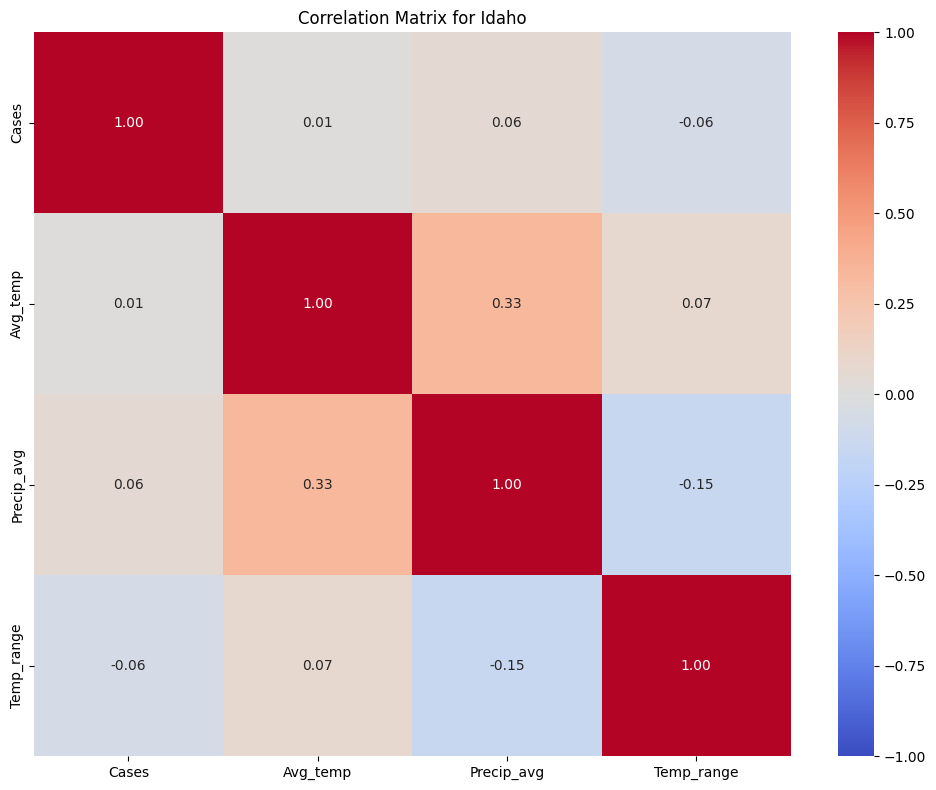

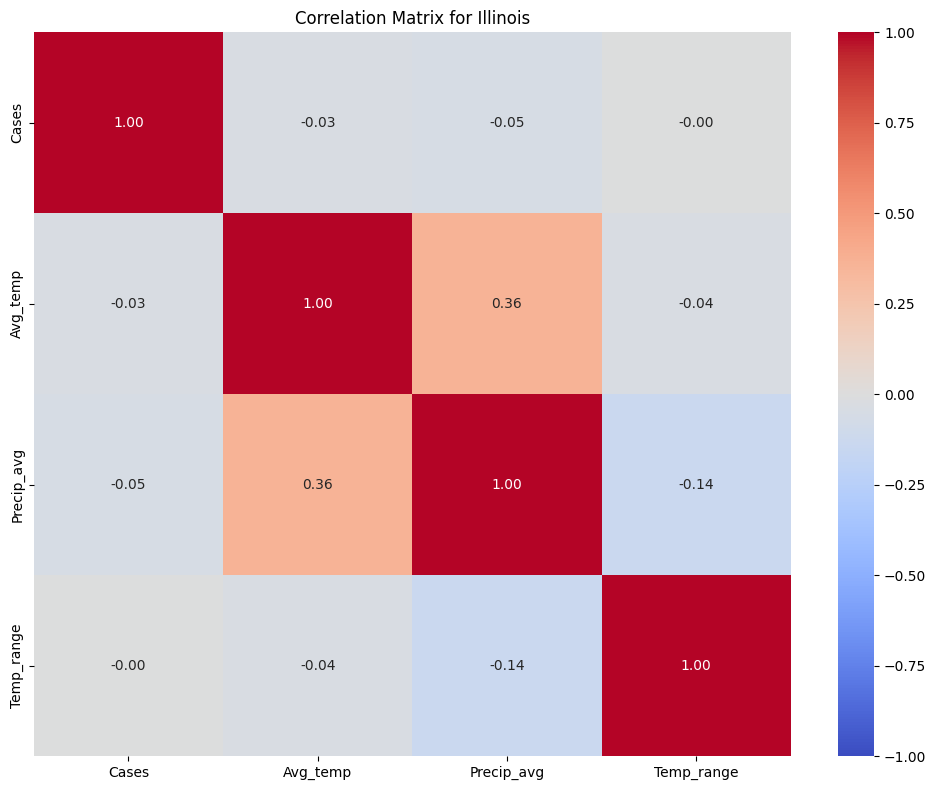

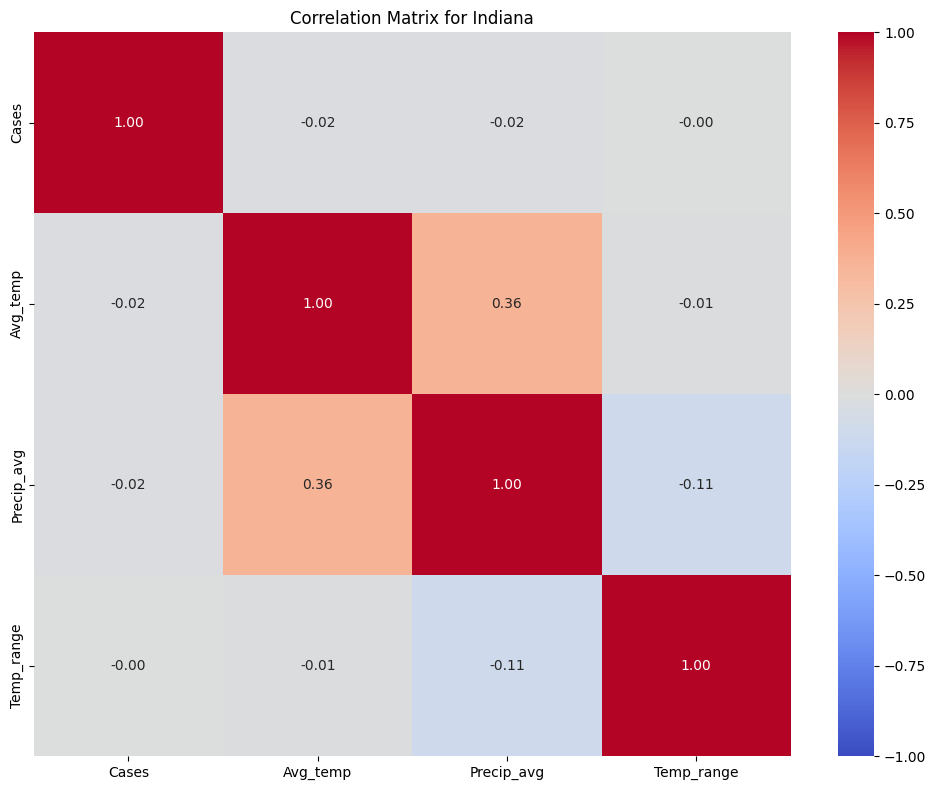

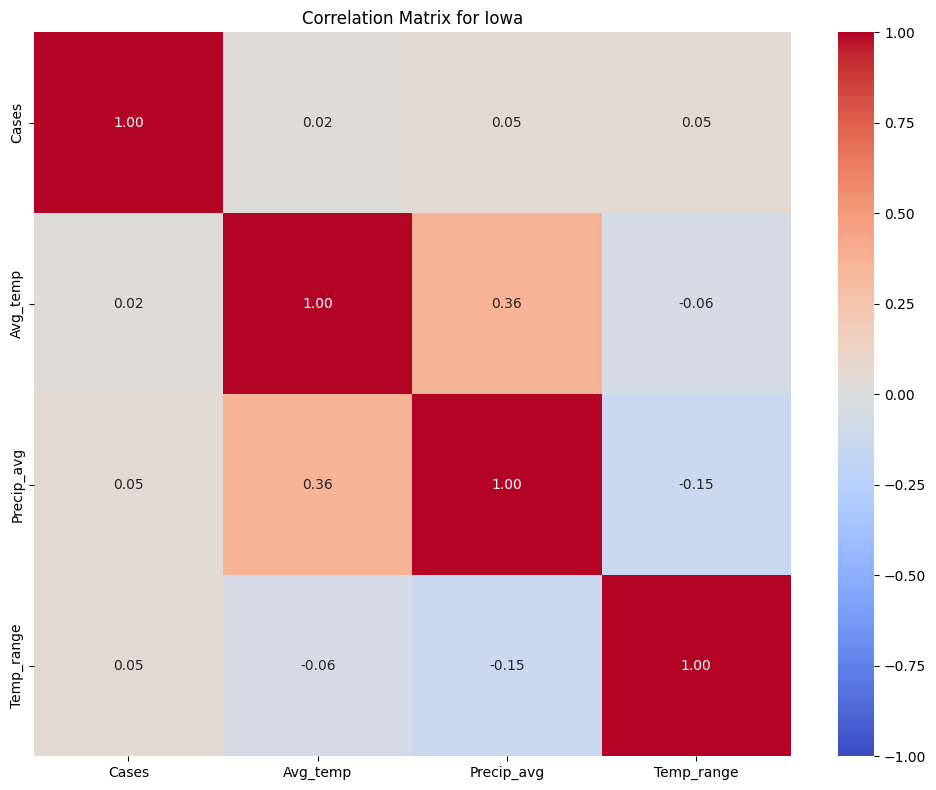

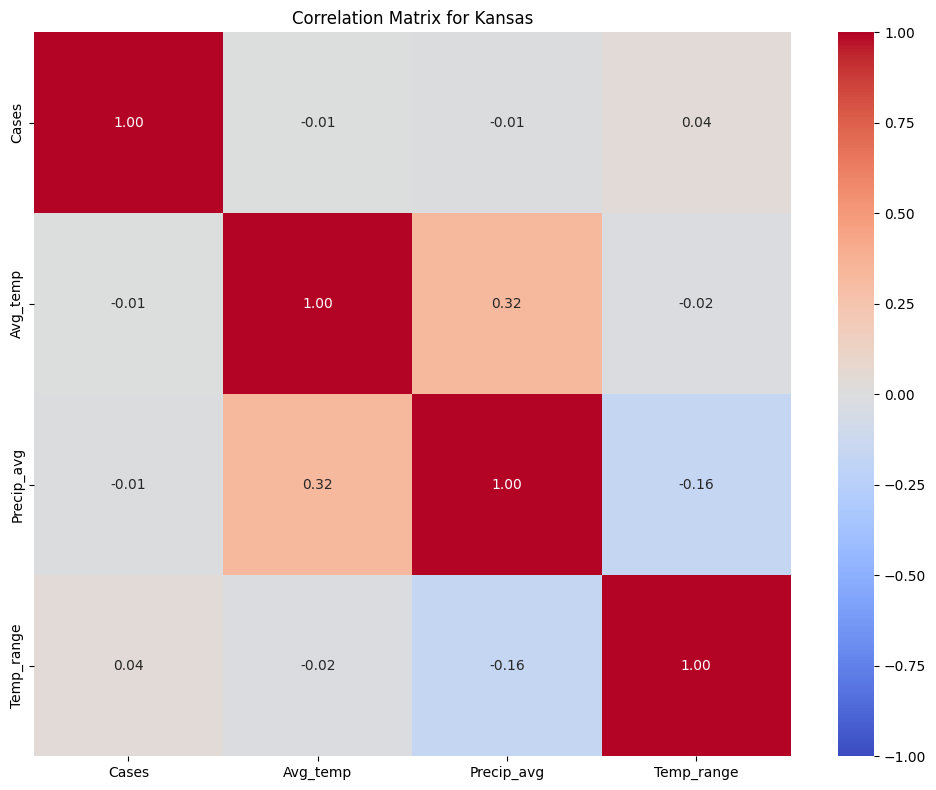

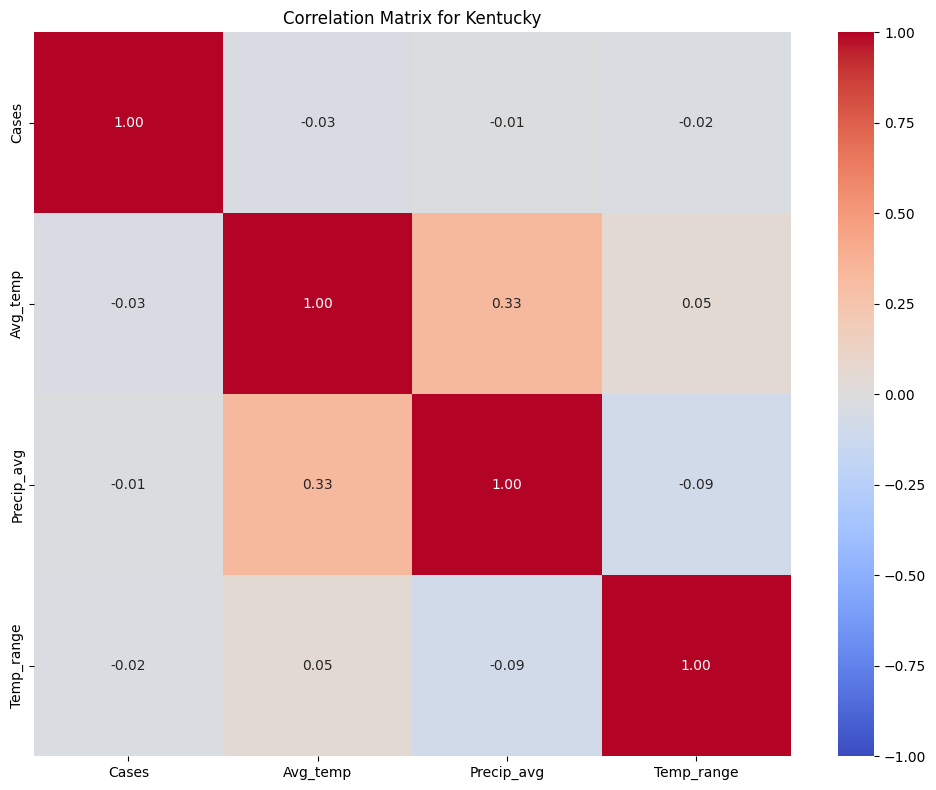

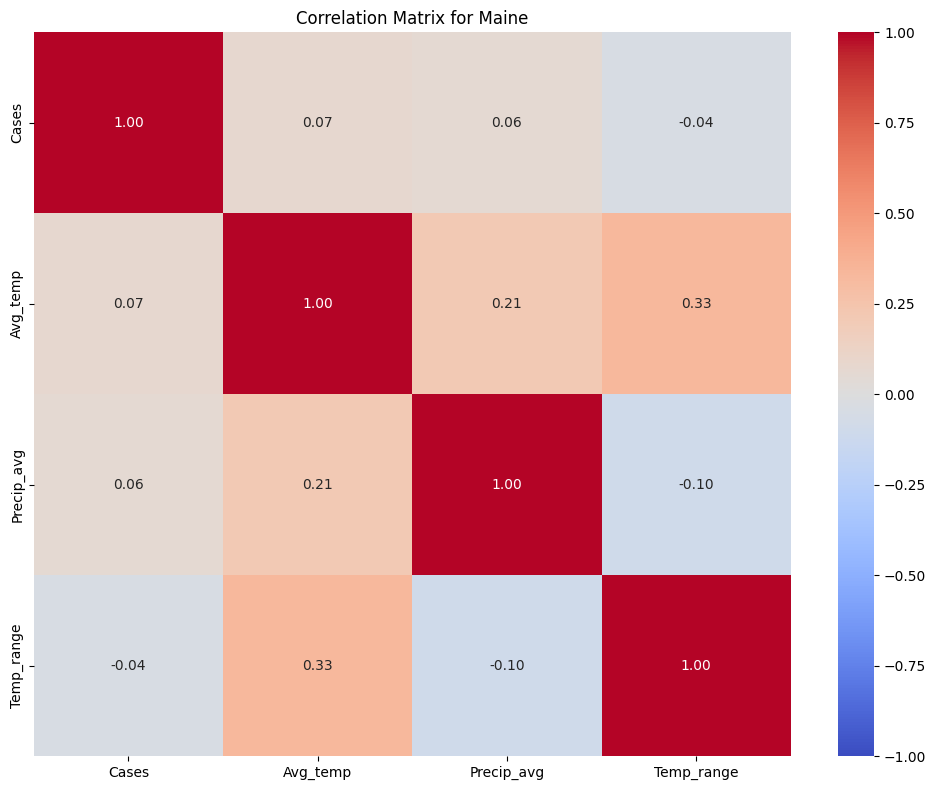

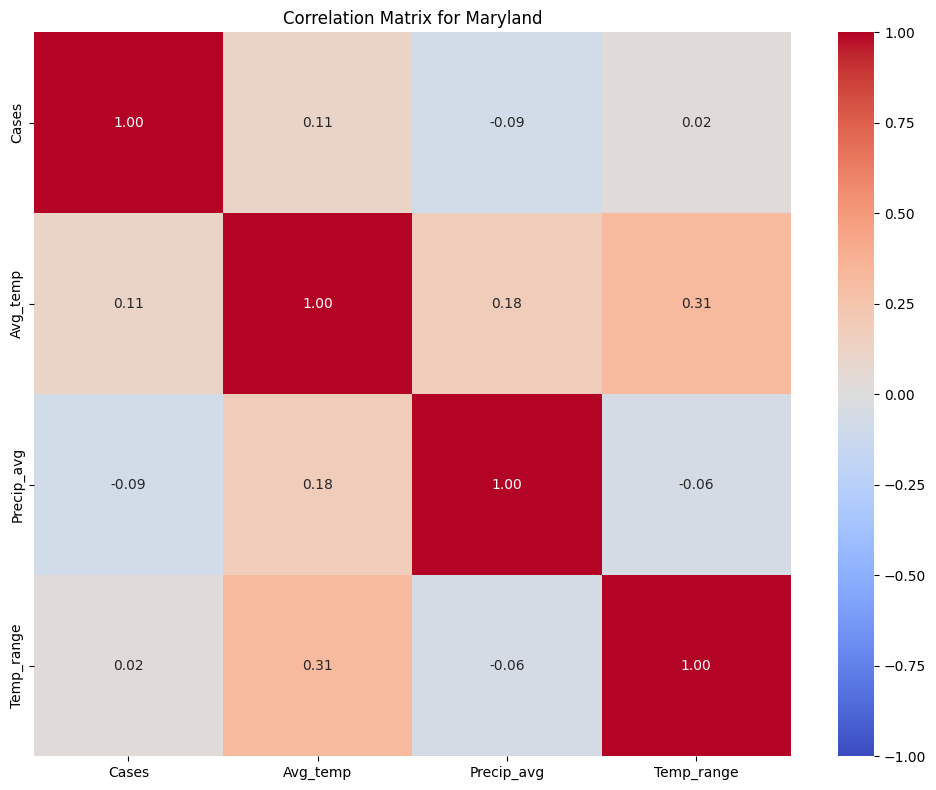

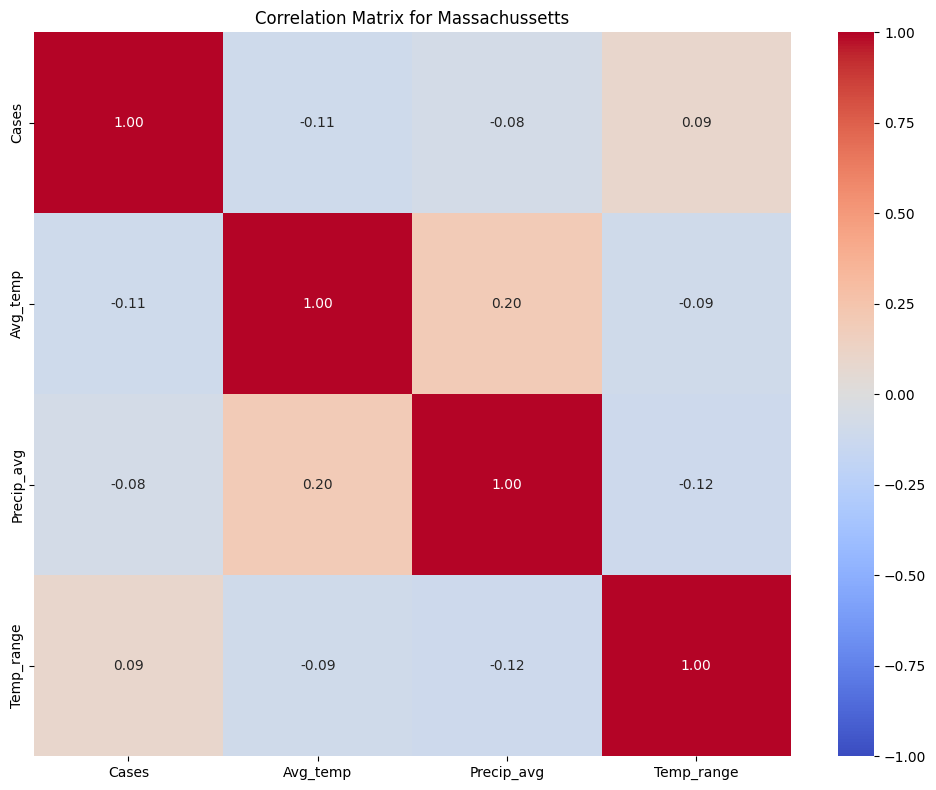

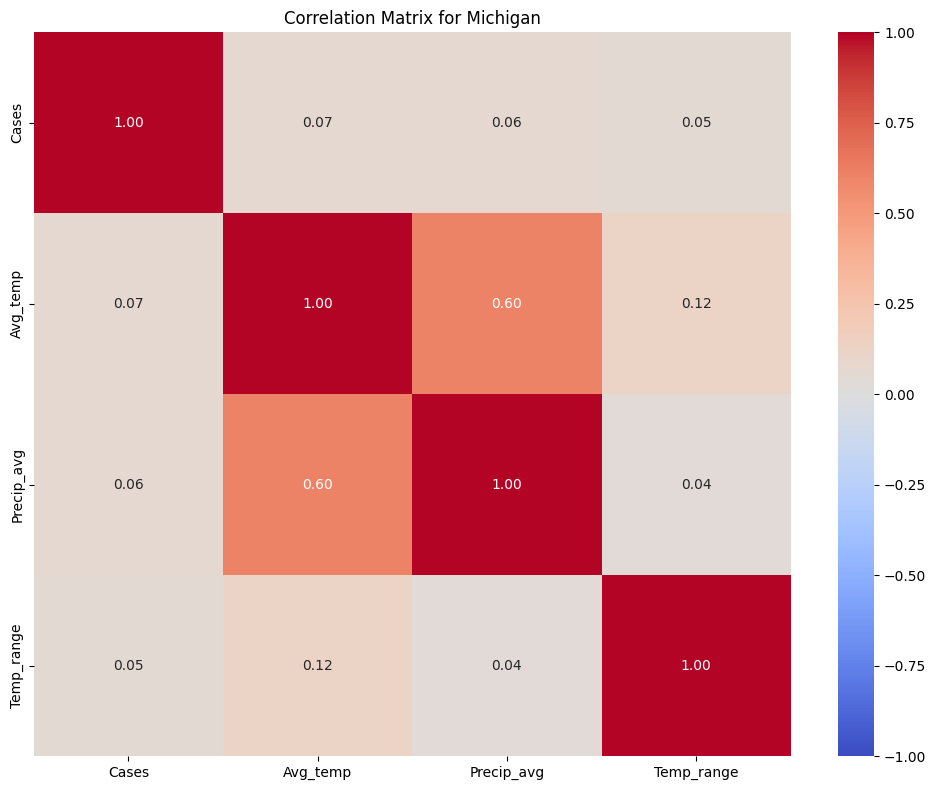

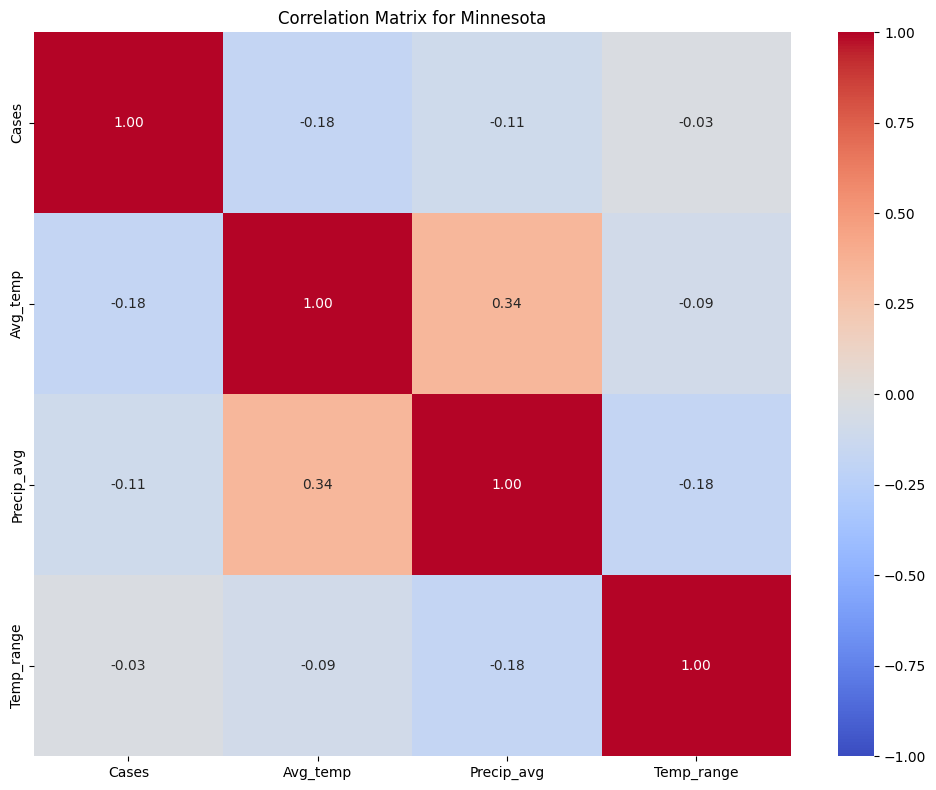

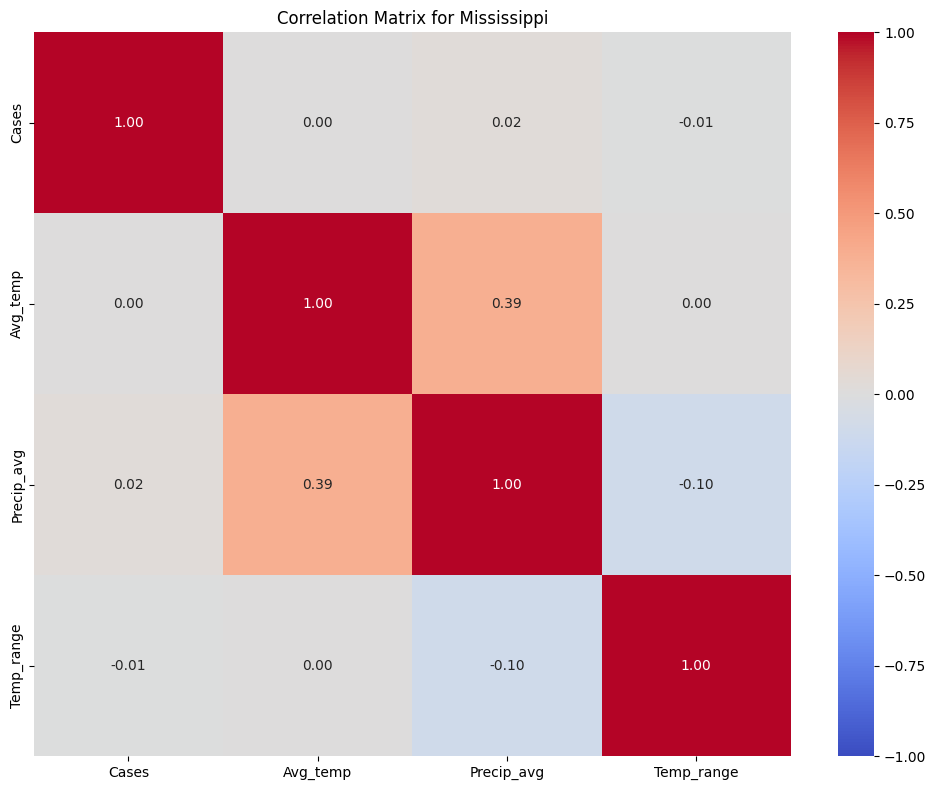

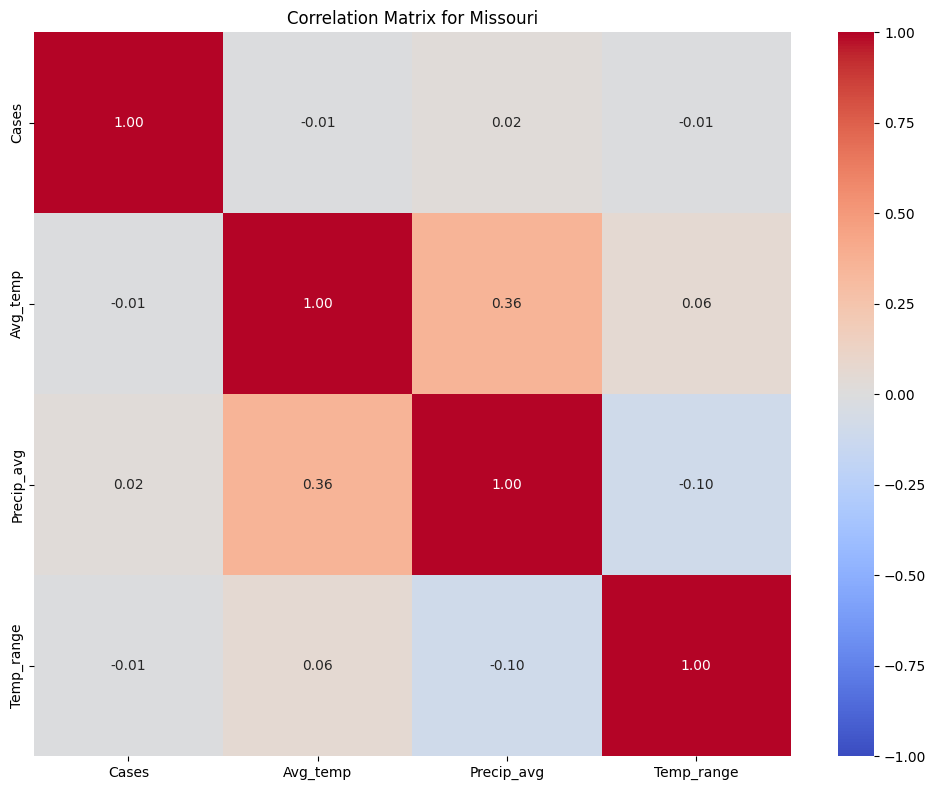

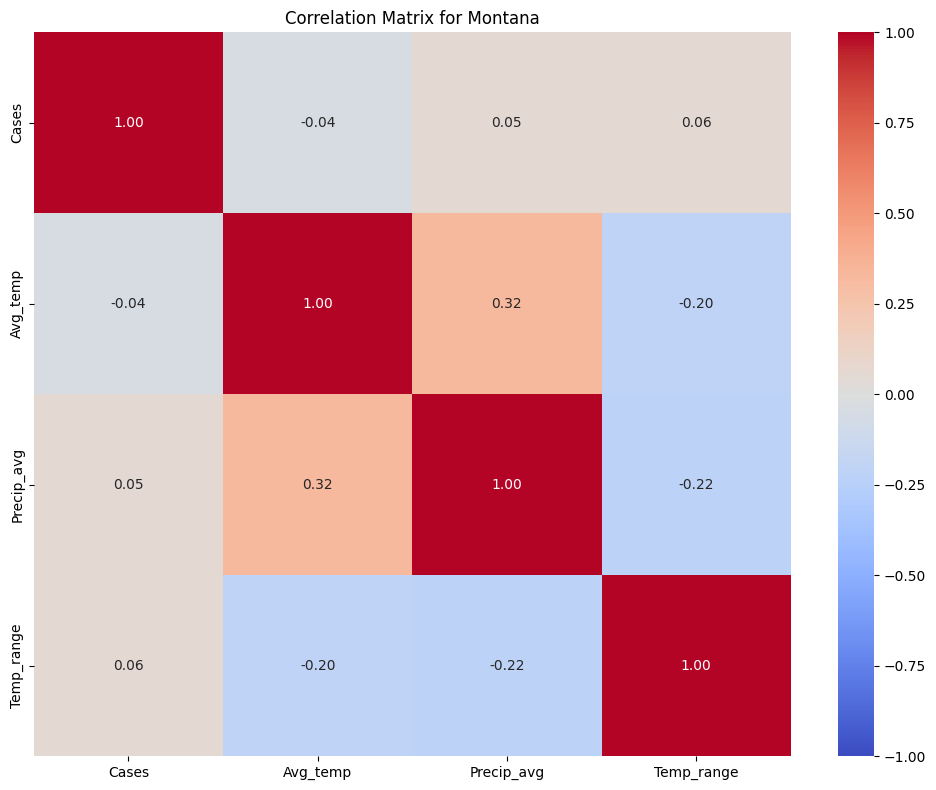

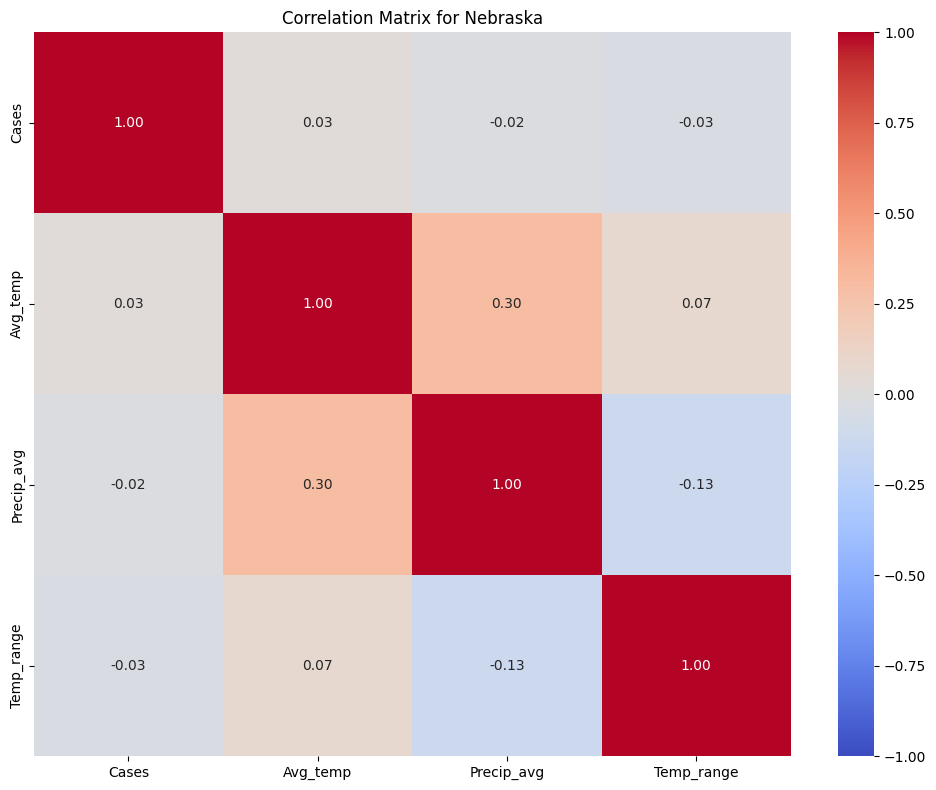

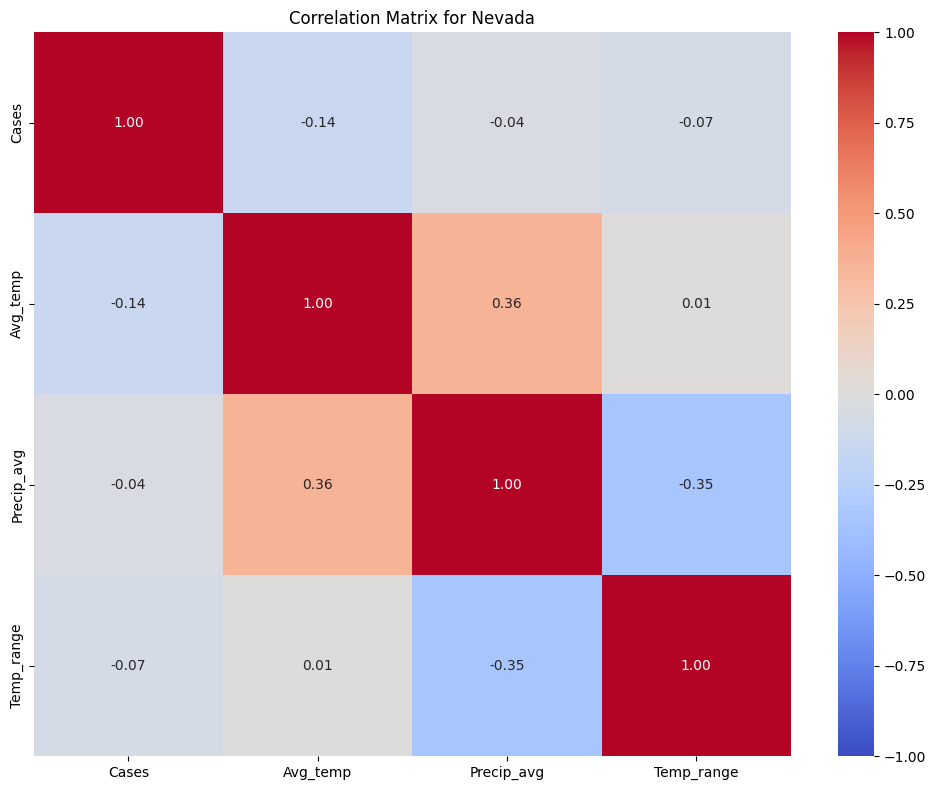

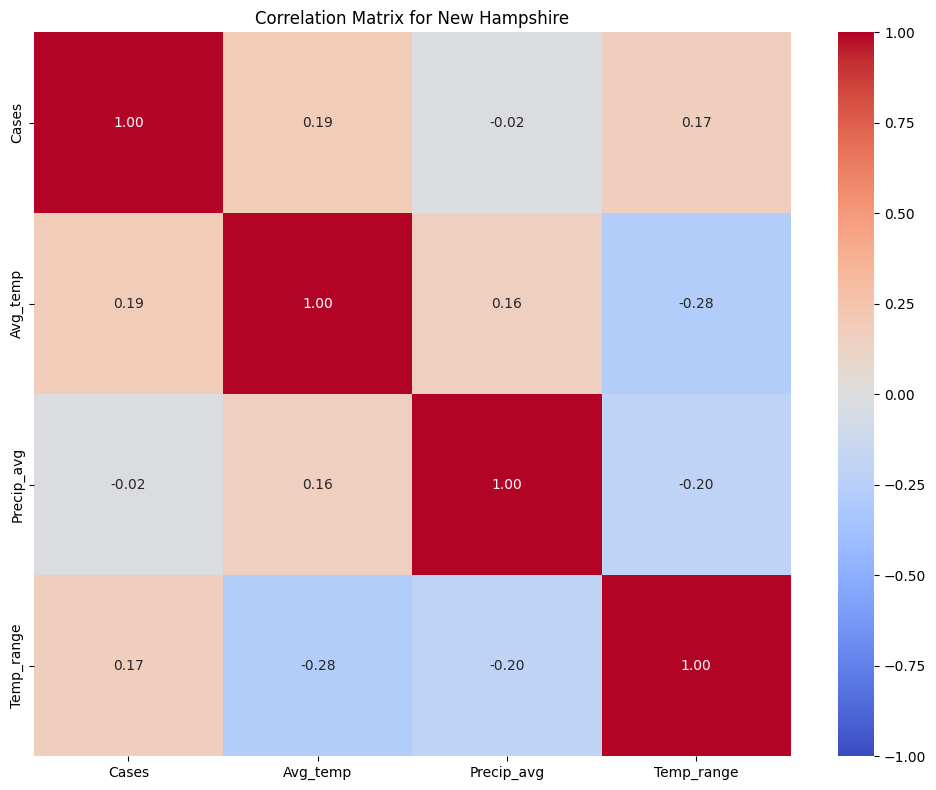

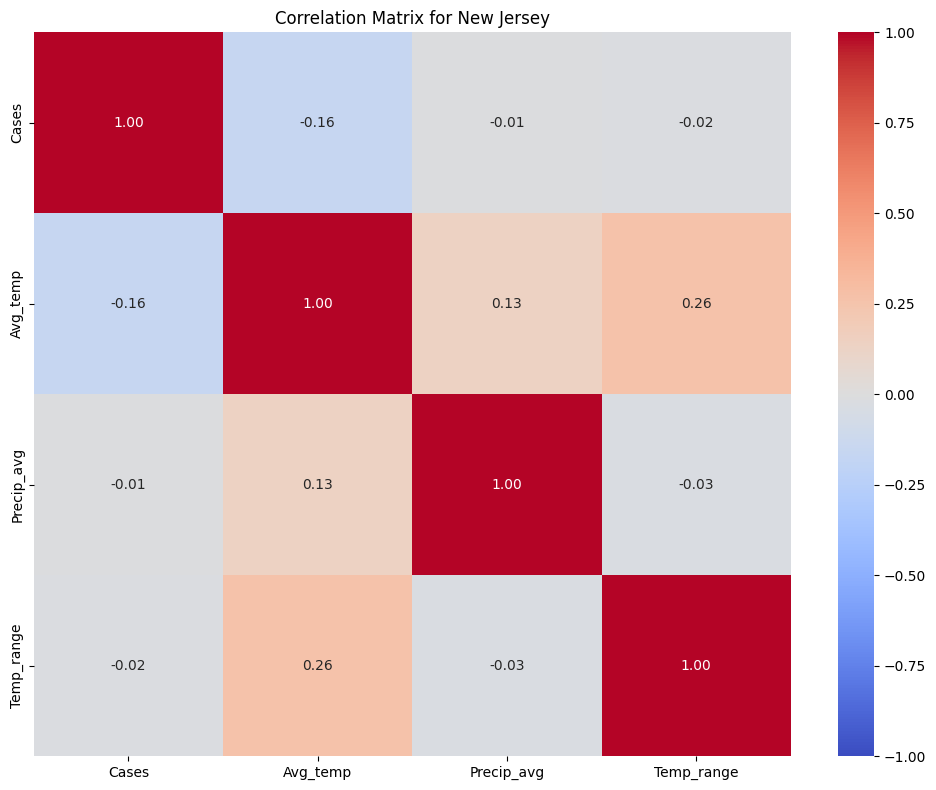

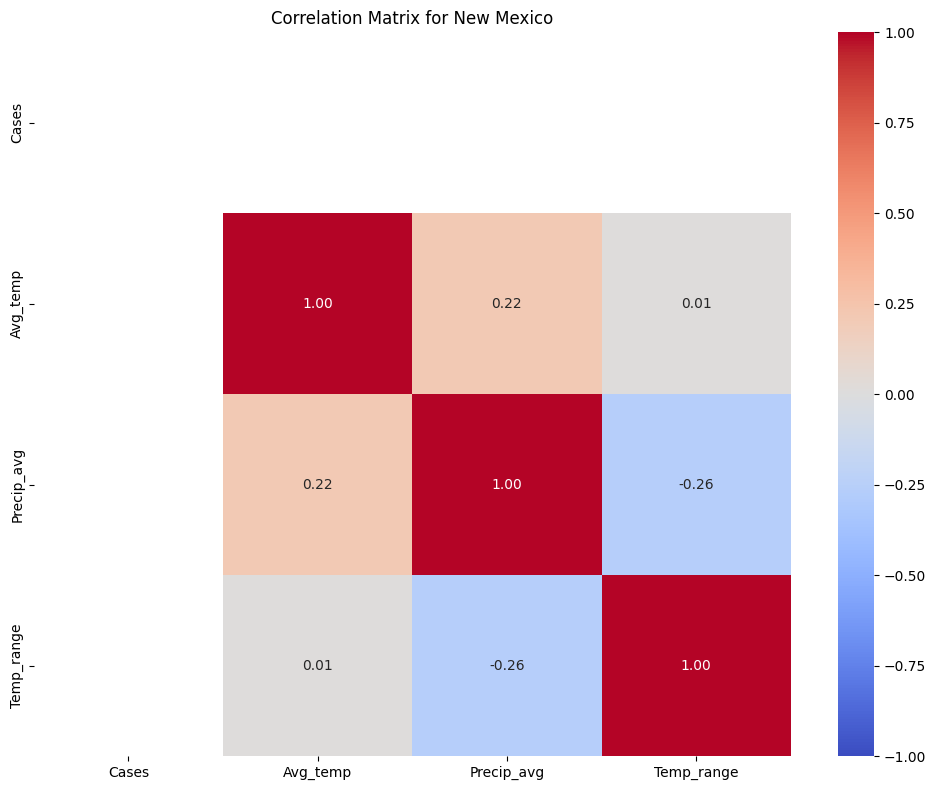

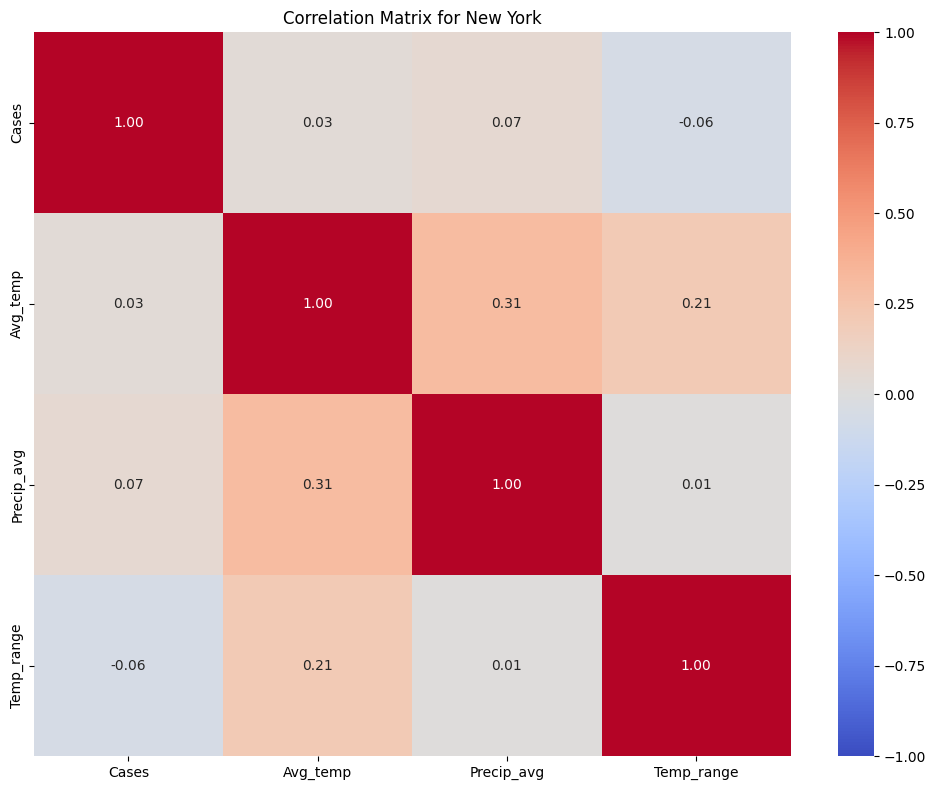

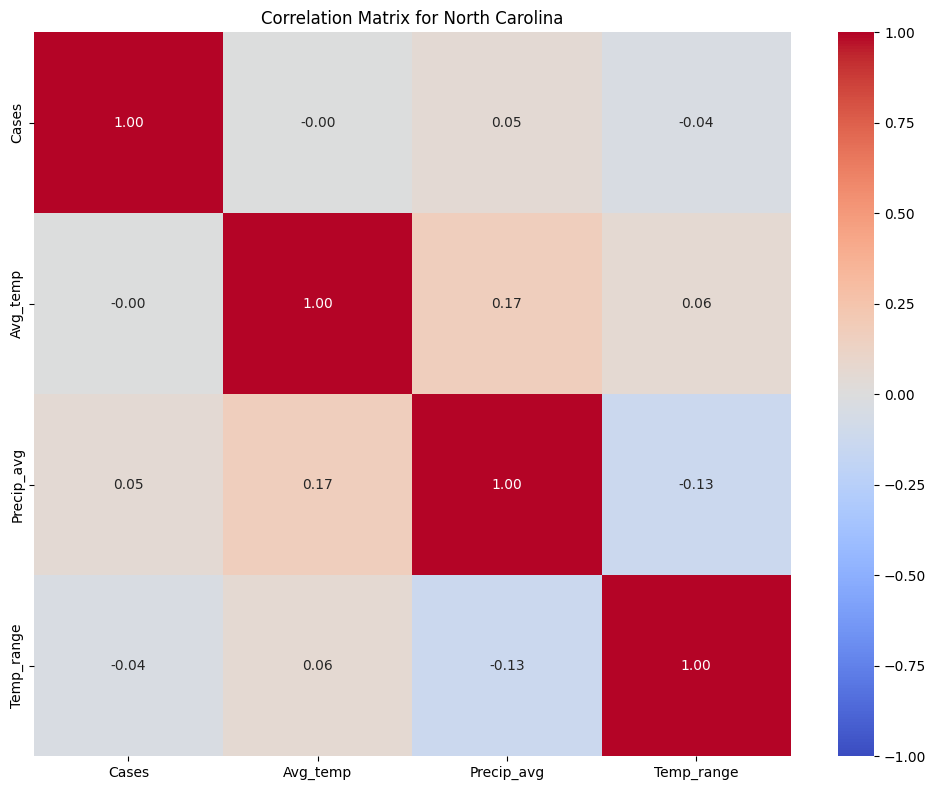

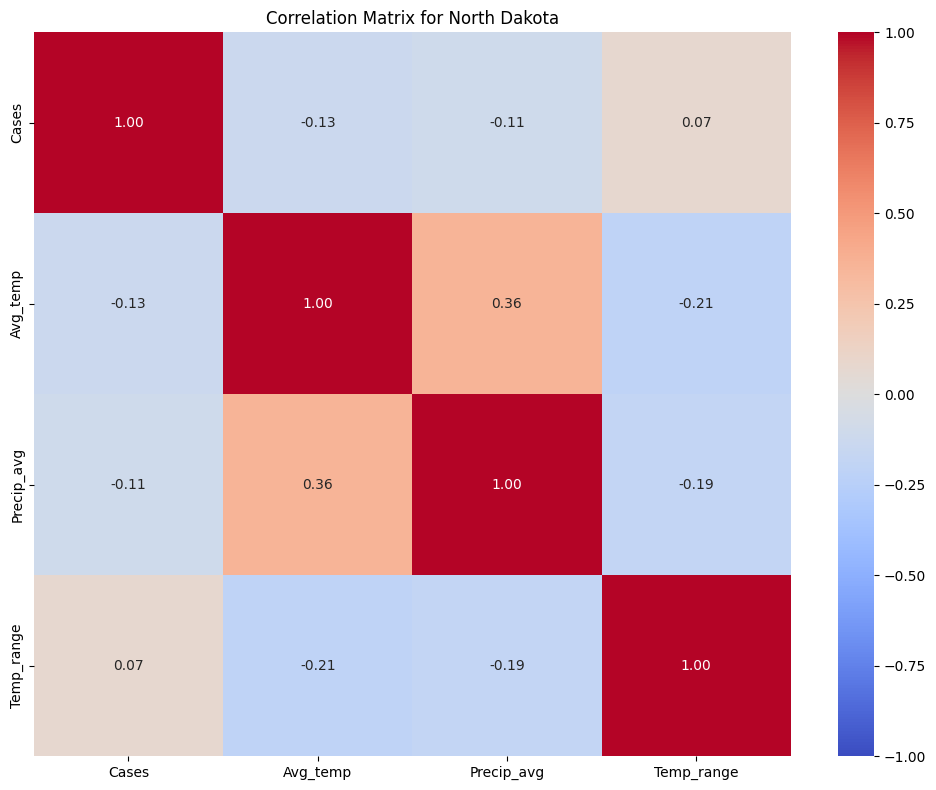

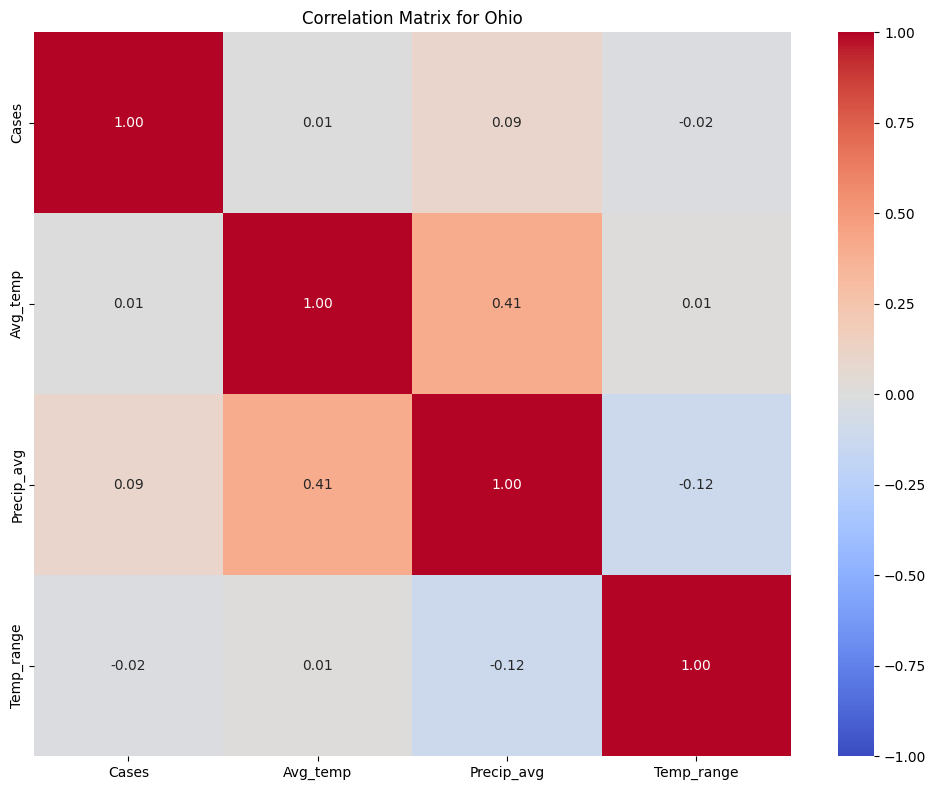

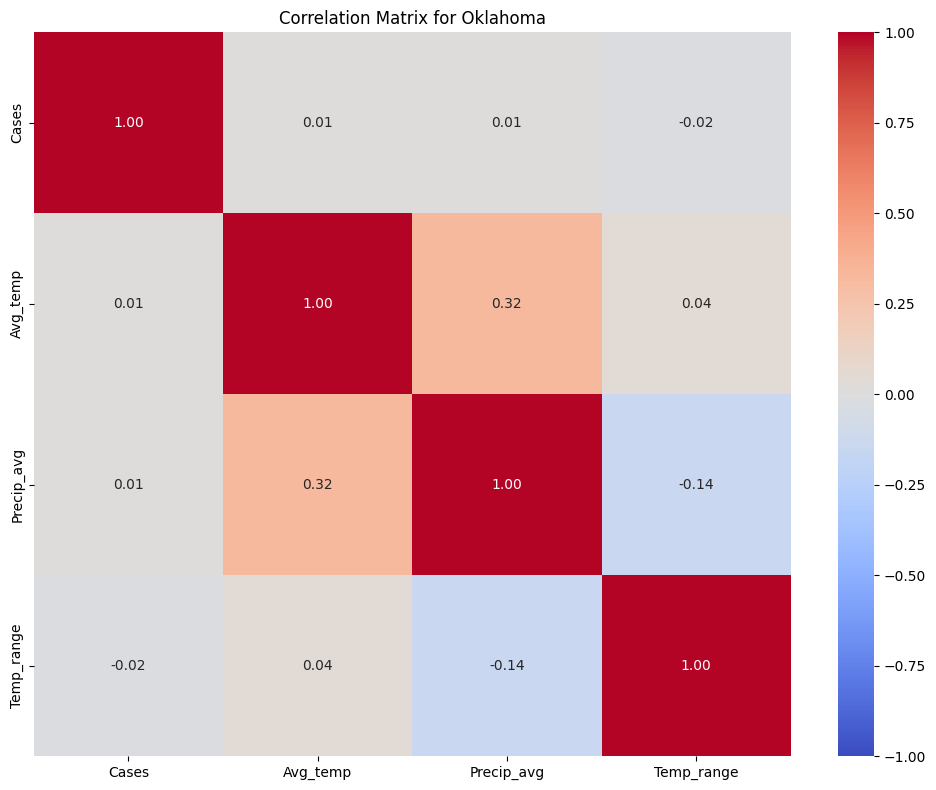

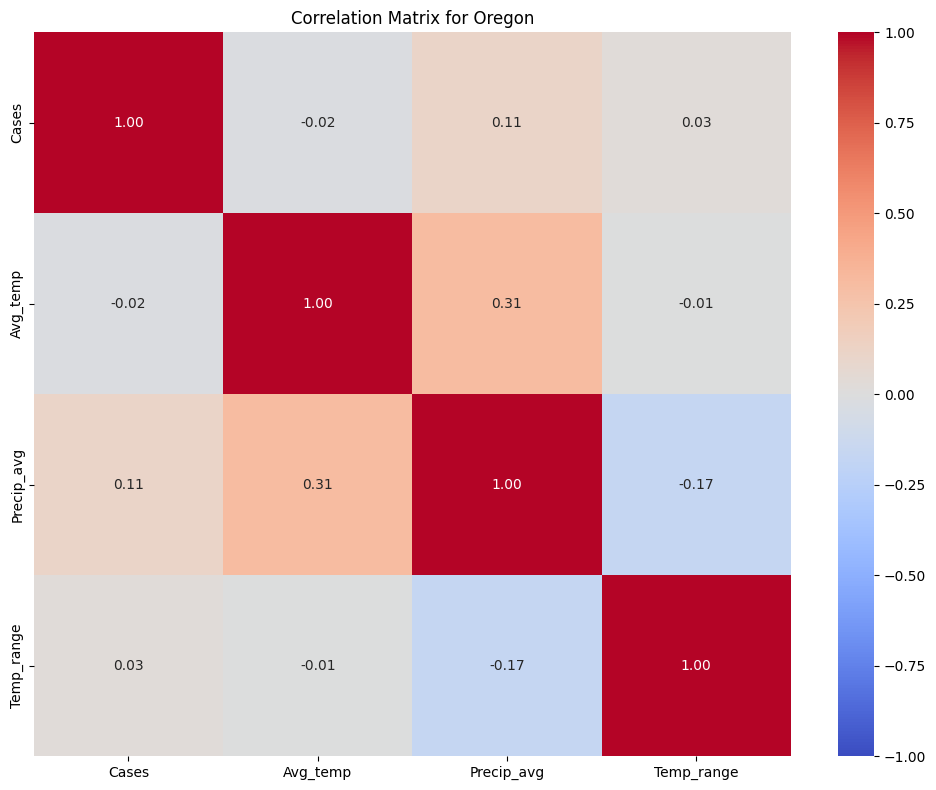

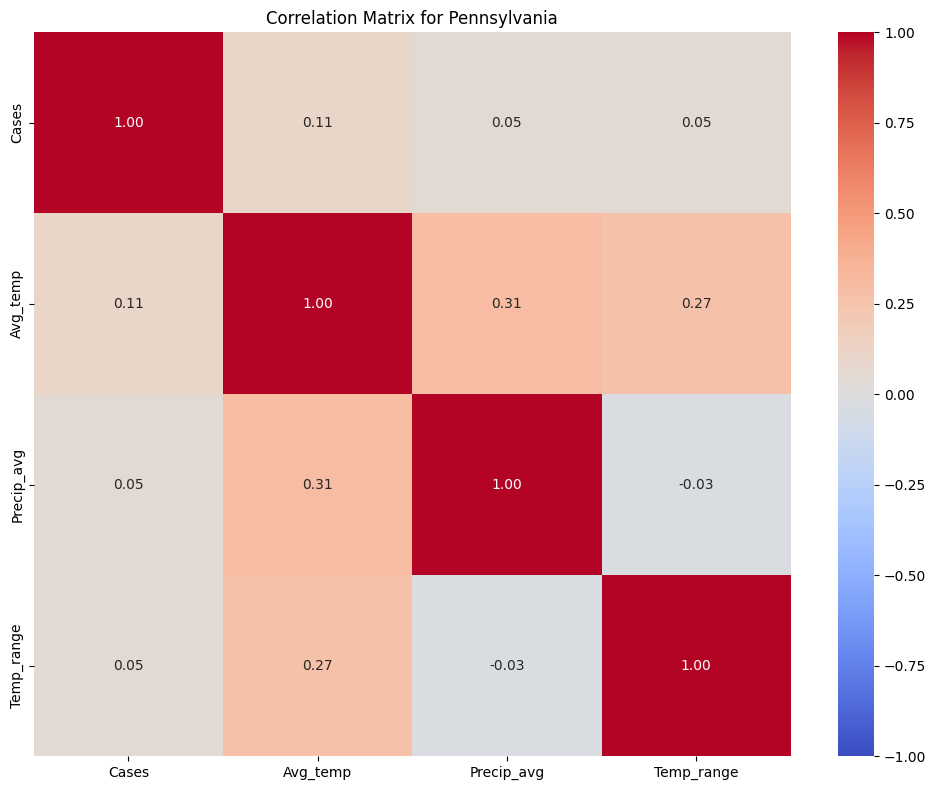

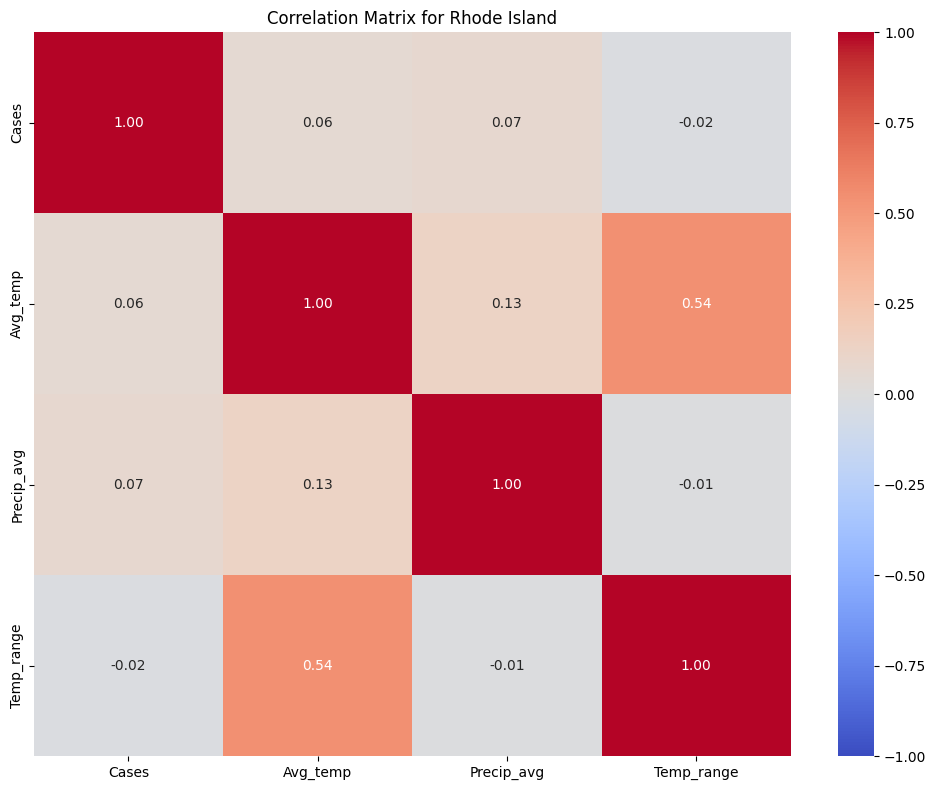

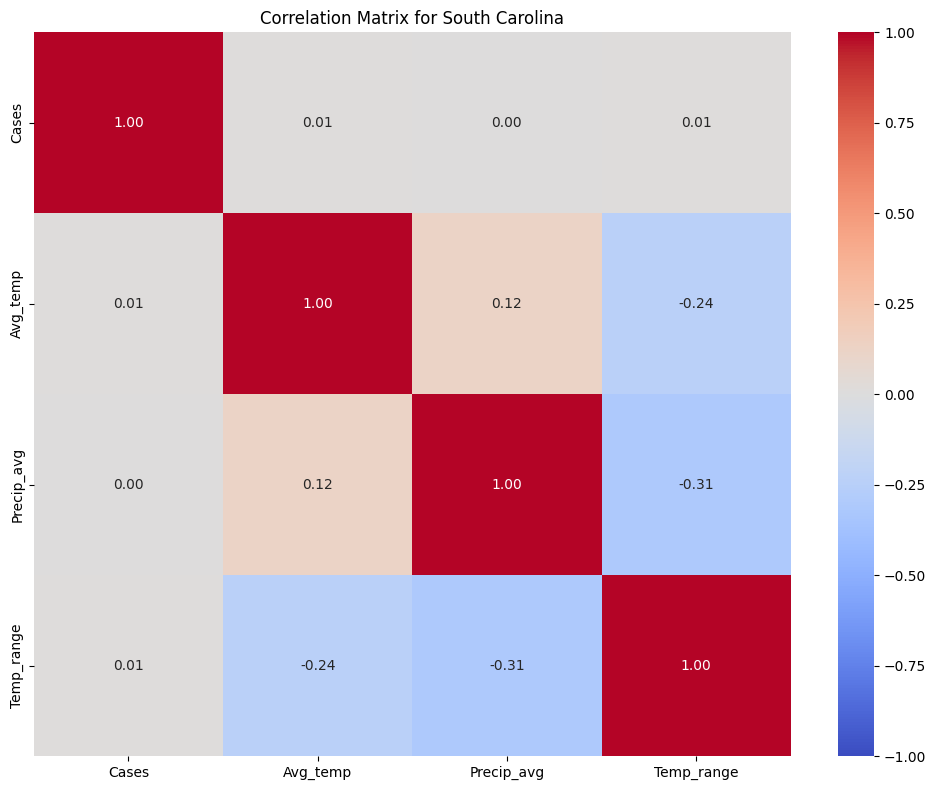

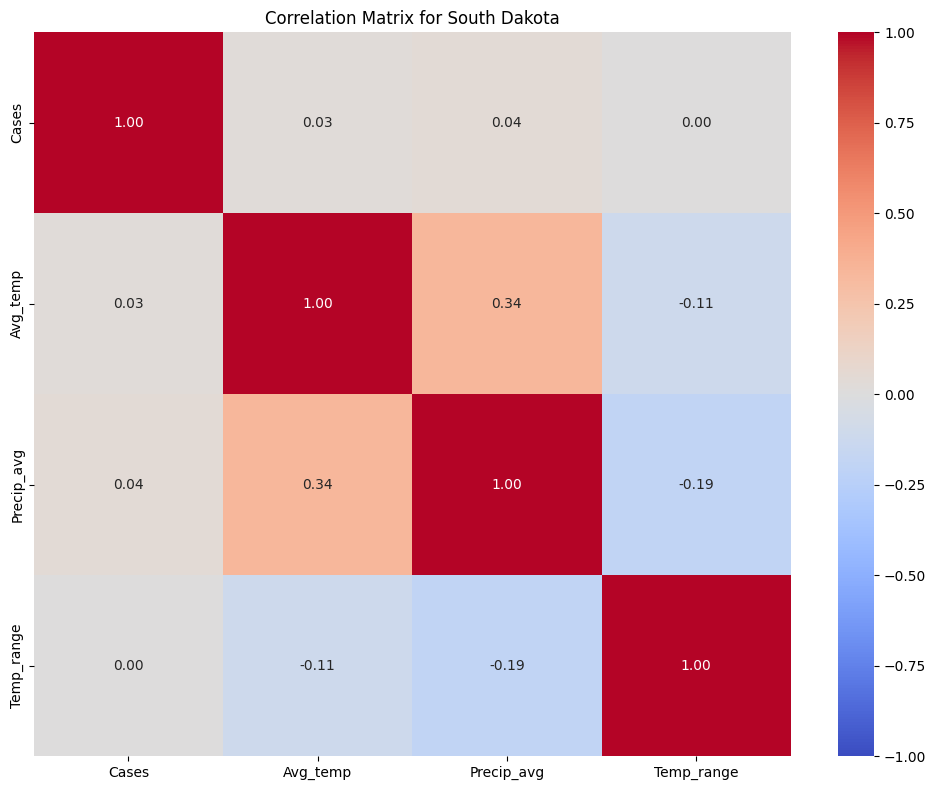

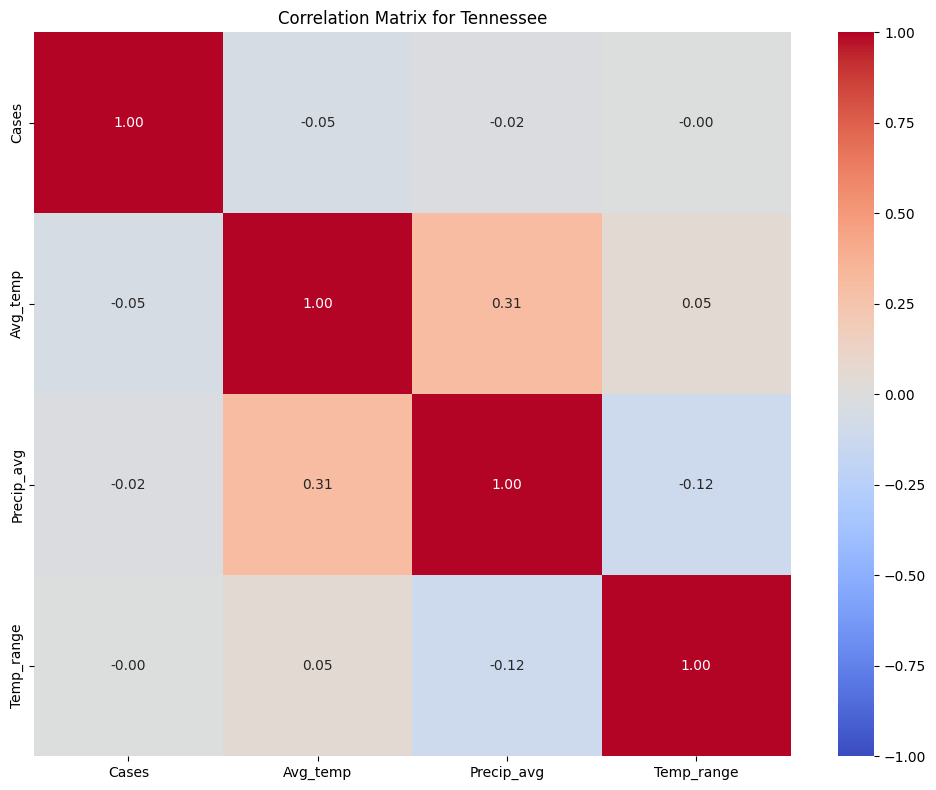

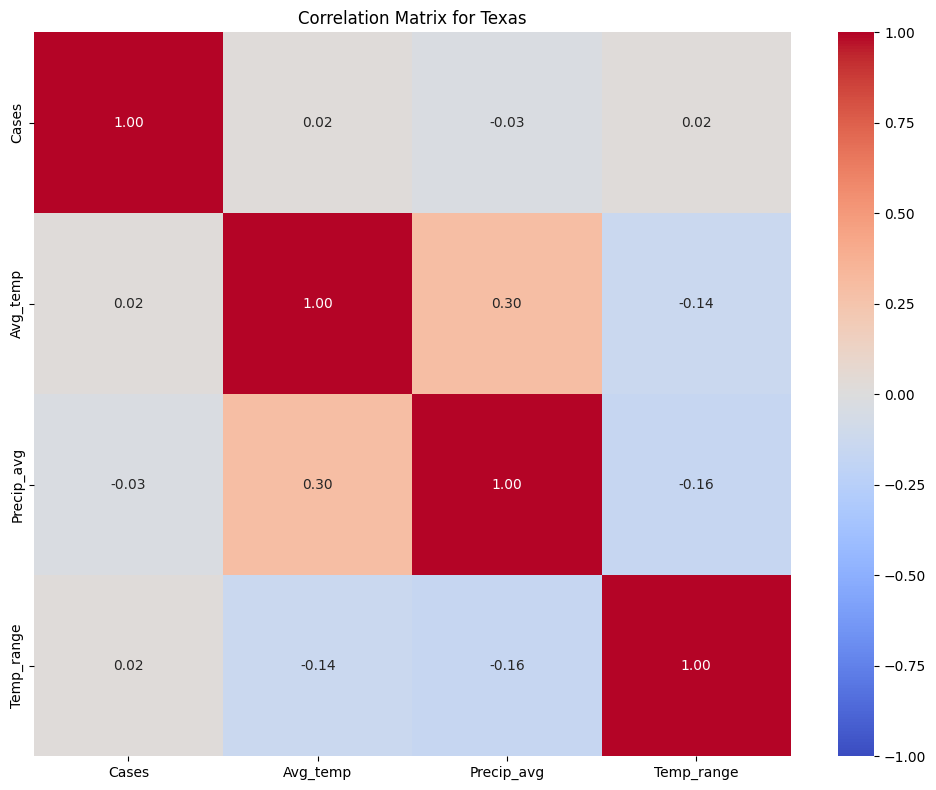

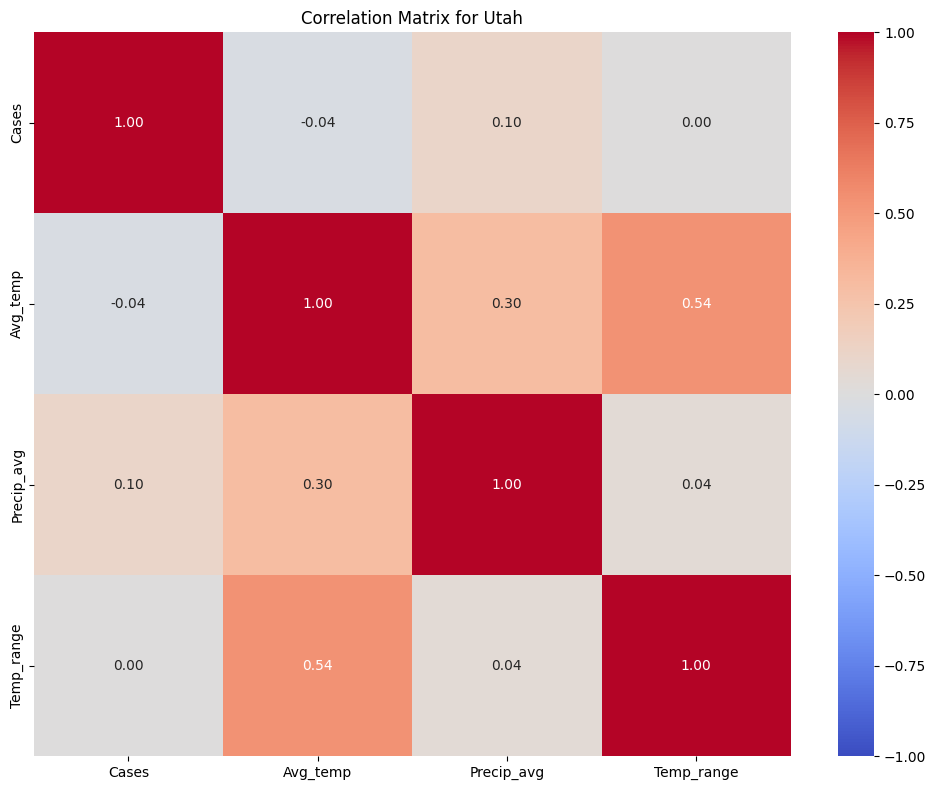

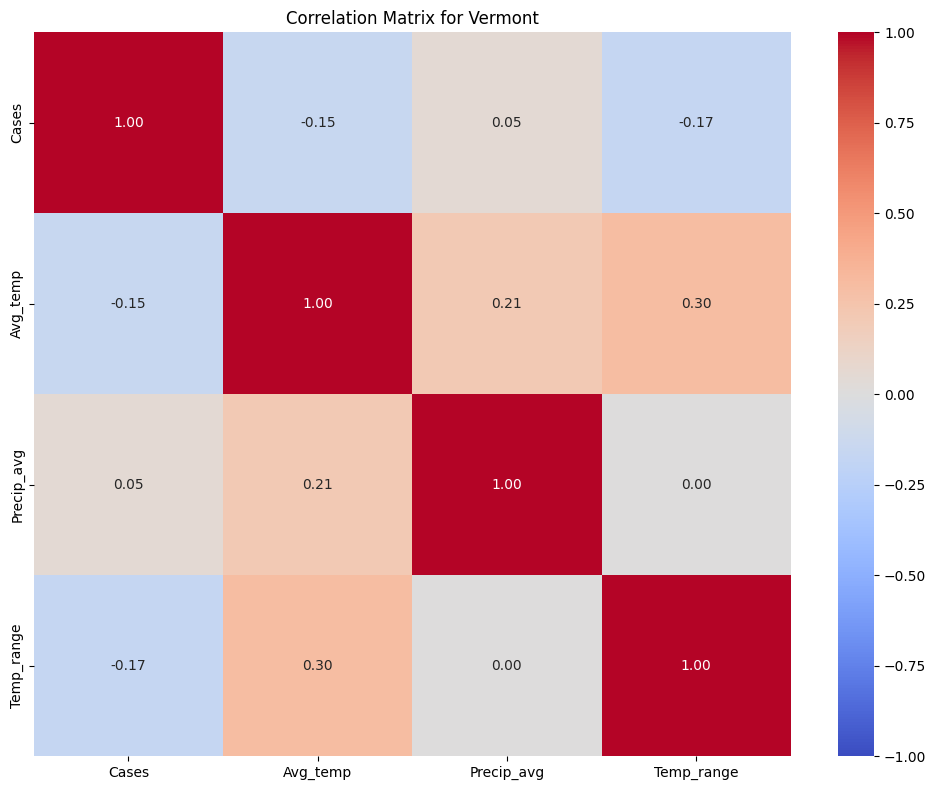

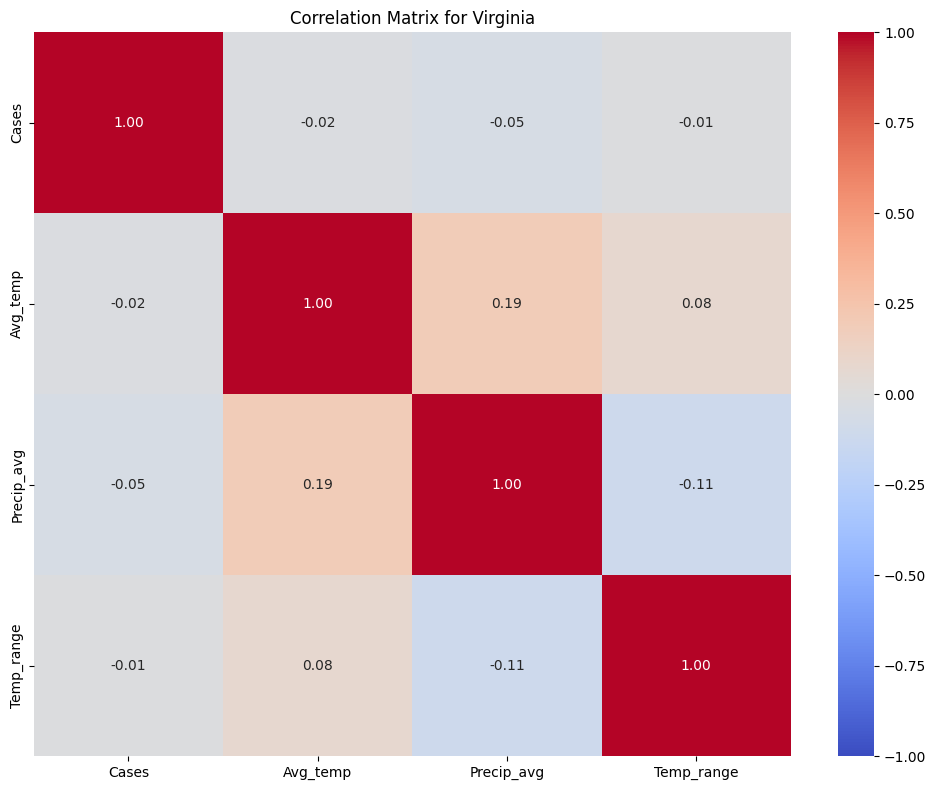

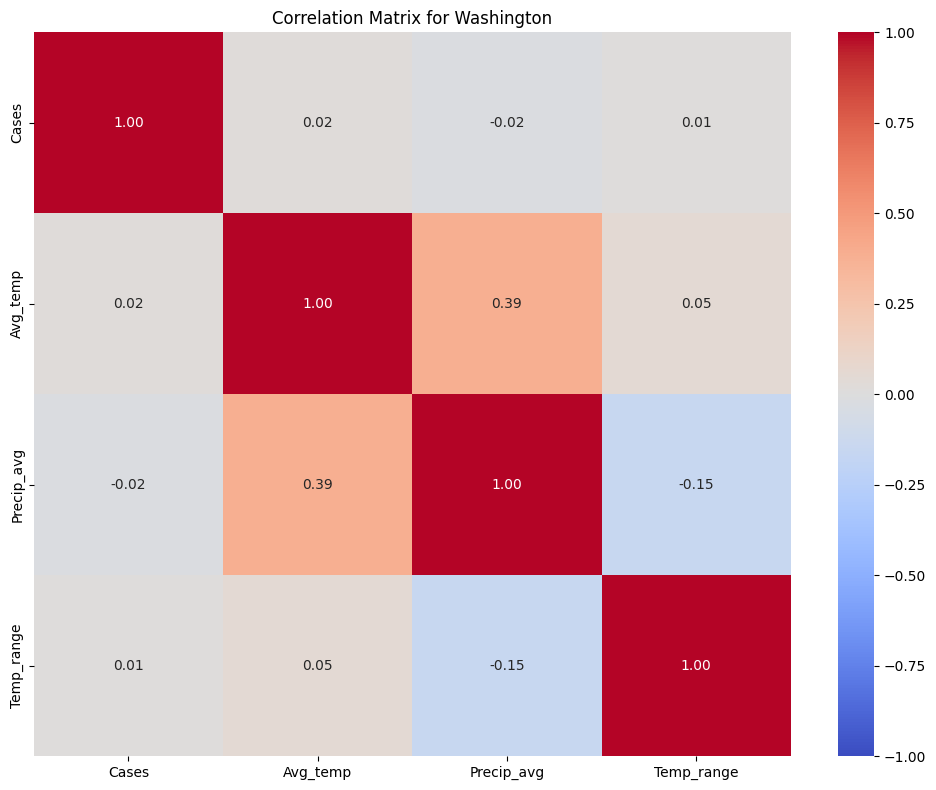

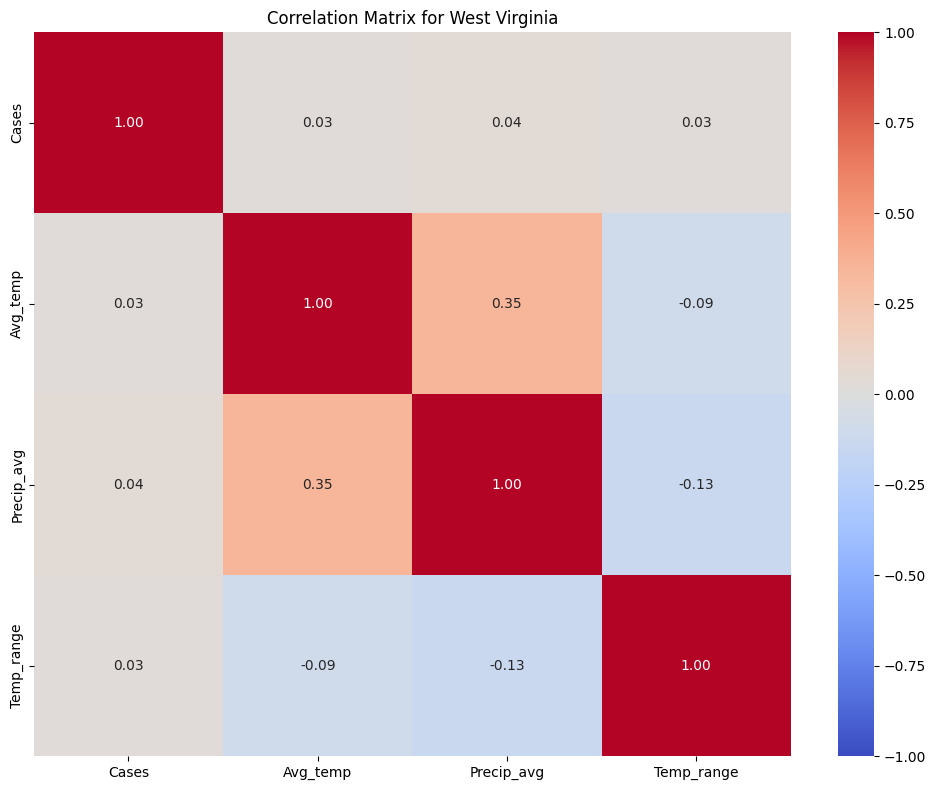

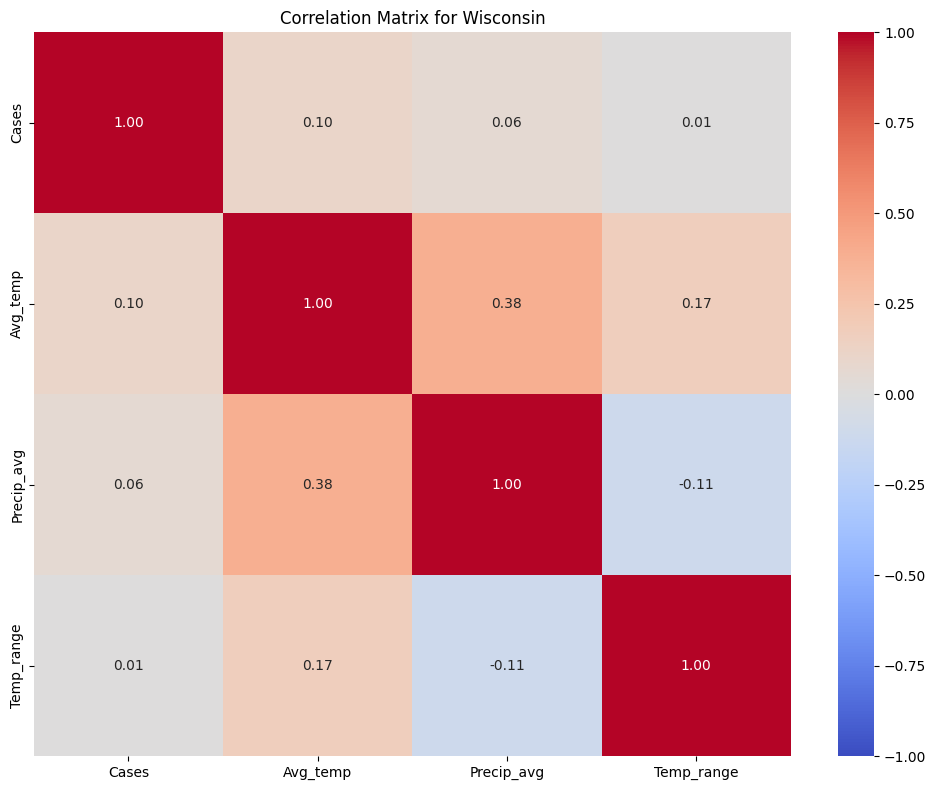

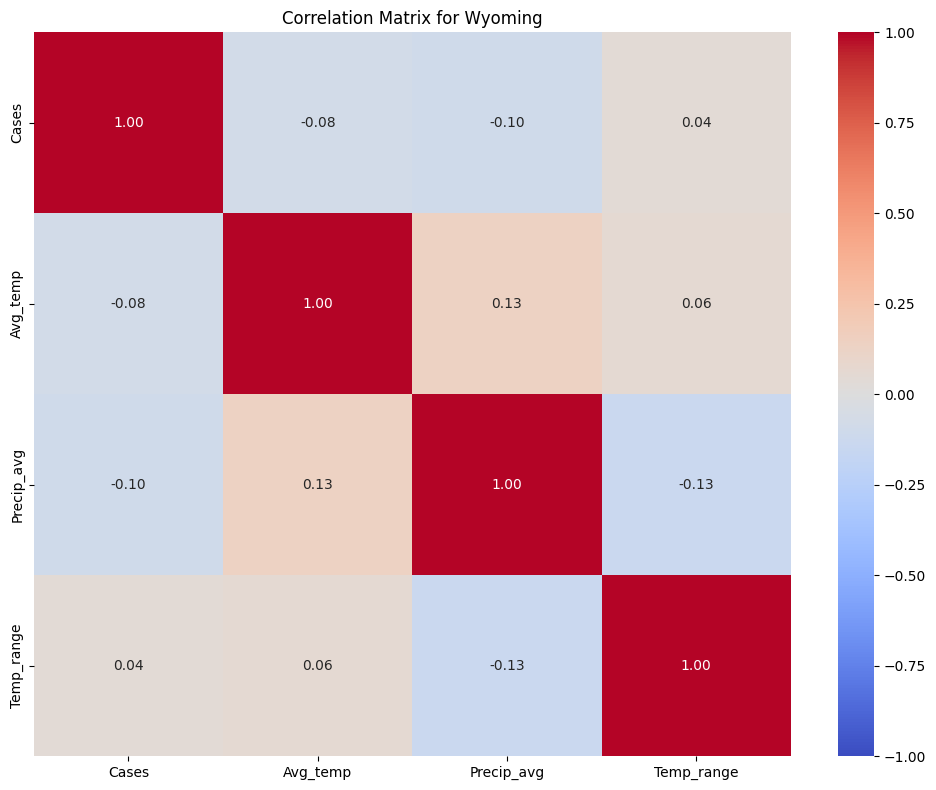

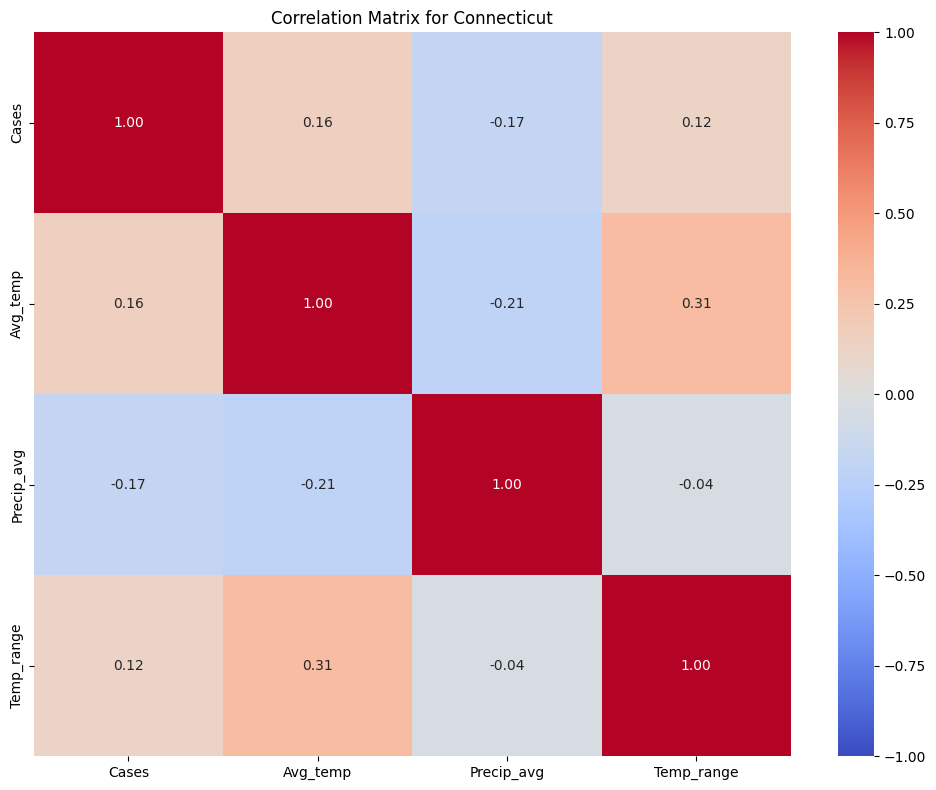

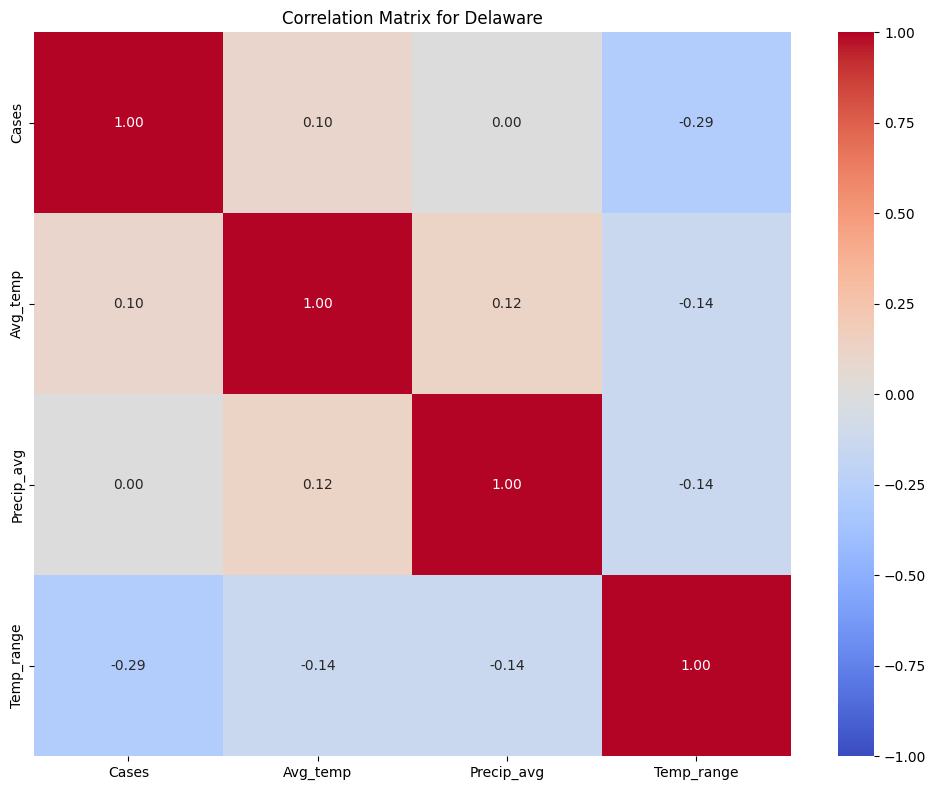

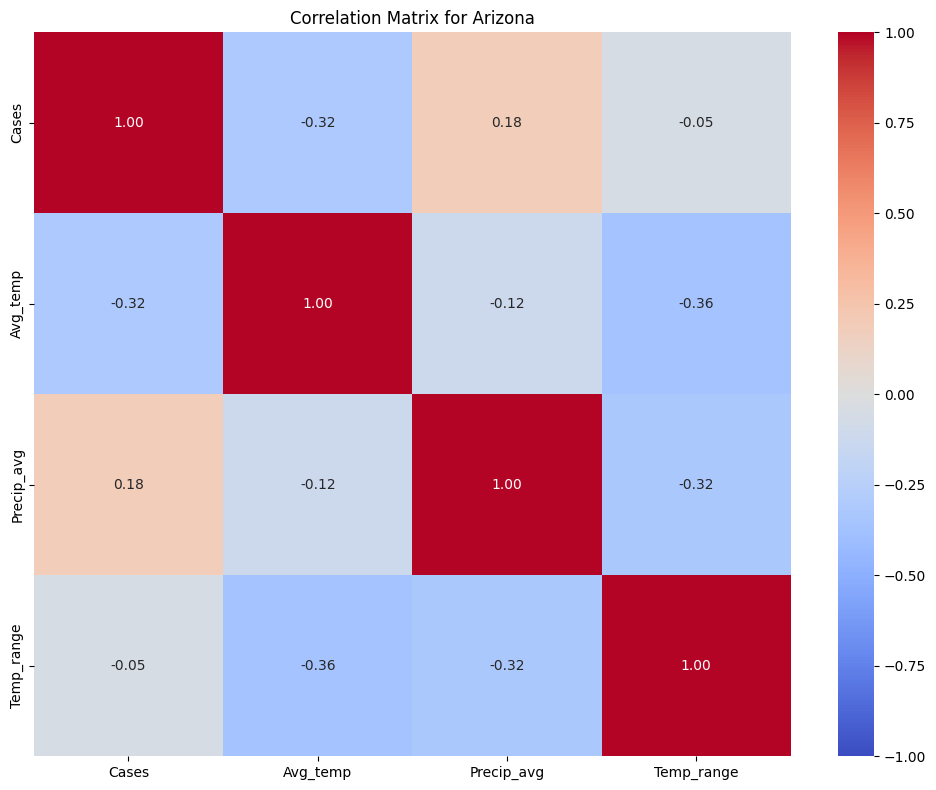

In [32]:
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')

# Try without lagged variables
correlation_columns = ['Cases', 'Avg_temp', 'Precip_avg', 'Temp_range']
for state in merged_data['stname'].unique():
    # Try for every state
    state_data = merged_data[merged_data['stname'] == state]
    correlation_data = state_data[correlation_columns]
    correlation_matrix = correlation_data.corr()
    
    # Plot the heatmap for the state
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix for {state}")
    plt.tight_layout()
    plt.show()


In [33]:


# Correlation matrix for every state sorted by highest to least correlation
merged_data['Year'] = pd.to_datetime(merged_data['Year'], format='%Y')
correlation_columns = ['Cases', 'Avg_temp', 'Precip_avg', 'Temp_range']
state_correlations = []

for state in merged_data['stname'].unique():
    state_data = merged_data[merged_data['stname'] == state]
    correlation_data = state_data[correlation_columns]
    correlation_matrix = correlation_data.corr()
    
    cases_precip_correlation = correlation_matrix.loc['Cases', 'Precip_avg']
    cases_temp_correlation = correlation_matrix.loc['Cases', 'Avg_temp']
    cases_temp_range_correlation = correlation_matrix.loc['Cases', 'Temp_range']

    # Ensure only cases vs. climatic variables are being assesed
    state_correlations.append({
        'State': state,
        'Cases vs. Precip_avg': cases_precip_correlation,
        'Cases vs. Avg_temp': cases_temp_correlation,
        'Cases vs. Temp_range': cases_temp_range_correlation
    })

# Create dataframe and sort it
correlations_df = pd.DataFrame(state_correlations)
correlations_df['Max_Correlation'] = correlations_df[['Cases vs. Precip_avg', 'Cases vs. Avg_temp', 'Cases vs. Temp_range']].abs().max(axis=1)
sorted_correlations = correlations_df.sort_values(by='Max_Correlation', ascending=False)

for index, row in sorted_correlations.iterrows():
    print(f"State: {row['State']}")
    print(f"  Cases vs. Precip_avg: {row['Cases vs. Precip_avg']:.2f}")
    print(f"  Cases vs. Avg_temp: {row['Cases vs. Avg_temp']:.2f}")
    print(f"  Cases vs. Temp_range: {row['Cases vs. Temp_range']:.2f}")
    print()


State: Arizona
  Cases vs. Precip_avg: 0.18
  Cases vs. Avg_temp: -0.32
  Cases vs. Temp_range: -0.05

State: Delaware
  Cases vs. Precip_avg: 0.00
  Cases vs. Avg_temp: 0.10
  Cases vs. Temp_range: -0.29

State: New Hampshire
  Cases vs. Precip_avg: -0.02
  Cases vs. Avg_temp: 0.19
  Cases vs. Temp_range: 0.17

State: Florida
  Cases vs. Precip_avg: 0.06
  Cases vs. Avg_temp: 0.18
  Cases vs. Temp_range: -0.09

State: Minnesota
  Cases vs. Precip_avg: -0.11
  Cases vs. Avg_temp: -0.18
  Cases vs. Temp_range: -0.03

State: Connecticut
  Cases vs. Precip_avg: -0.17
  Cases vs. Avg_temp: 0.16
  Cases vs. Temp_range: 0.12

State: Vermont
  Cases vs. Precip_avg: 0.05
  Cases vs. Avg_temp: -0.15
  Cases vs. Temp_range: -0.17

State: New Jersey
  Cases vs. Precip_avg: -0.01
  Cases vs. Avg_temp: -0.16
  Cases vs. Temp_range: -0.02

State: Nevada
  Cases vs. Precip_avg: -0.04
  Cases vs. Avg_temp: -0.14
  Cases vs. Temp_range: -0.07

State: North Dakota
  Cases vs. Precip_avg: -0.11
  Cases v

Step 3: Creating models

In [26]:
# Filter data for a given state
minnesota_data = merged_data[merged_data['stname'] == 'STATE NAME HERE']
minnesota_data['Year'] = pd.to_datetime(minnesota_data['Year'], format='%Y')
minnesota_data = minnesota_data[['Year', 'County Name', 'Cases', 'Avg_temp', 'Precip_avg', 'Temp_range']]

minnesota_data = minnesota_data.dropna() 

# Create lagged variables for climate data
minnesota_data['Avg_temp_lag1'] = minnesota_data.groupby('County Name')['Avg_temp'].shift(1)
minnesota_data['Precip_avg_lag1'] = minnesota_data.groupby('County Name')['Precip_avg'].shift(1)
minnesota_data['Temp_range_lag1'] = minnesota_data.groupby('County Name')['Temp_range'].shift(1)

minnesota_data = minnesota_data.dropna()
print(minnesota_data.head())


           Year    County Name  Cases   Avg_temp  Precip_avg  Temp_range  \
4266 2001-01-01  Benton County    6.0  60.725000    5.530833        63.8   
4267 2001-01-01  Benton County    6.0  59.141667    4.971667        64.4   
4277 2001-01-01    Cass County   17.0  51.700000    3.656667        60.1   
4278 2001-01-01    Cass County   17.0  50.133333    3.365833        67.1   
4283 2001-01-01    Clay County    0.0  69.250000    4.069167        56.6   

      Avg_temp_lag1  Precip_avg_lag1  Temp_range_lag1  
4266      51.816667         3.408333             69.6  
4267      60.725000         5.530833             63.8  
4277      53.916667         3.157500             66.7  
4278      51.700000         3.656667             60.1  
4283      60.583333         4.725000             60.2  


/var/folders/yx/1rq_7r716y7bj5qgc38hr98m0000gn/T/ipykernel_971/3670246899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  minnesota_data['Year'] = pd.to_datetime(minnesota_data['Year'], format='%Y')


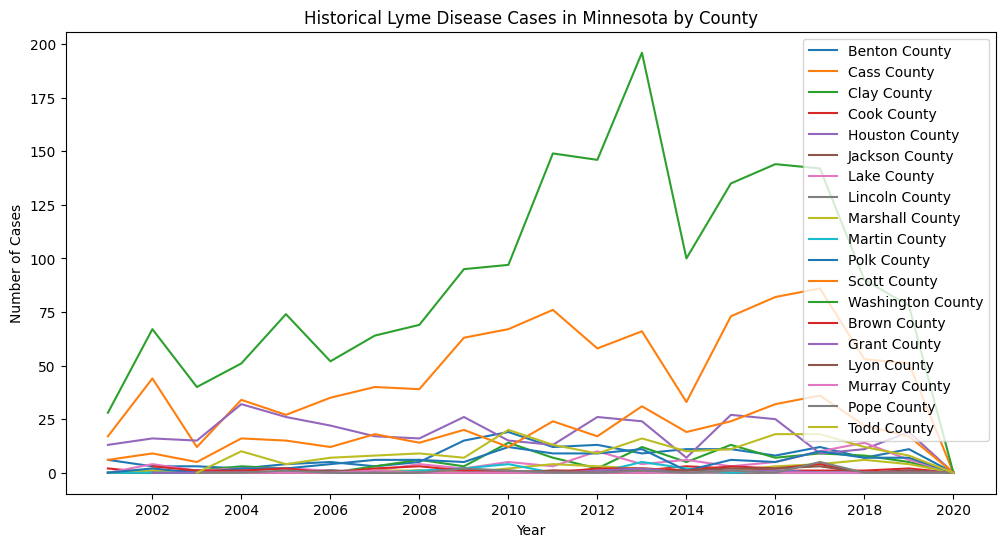

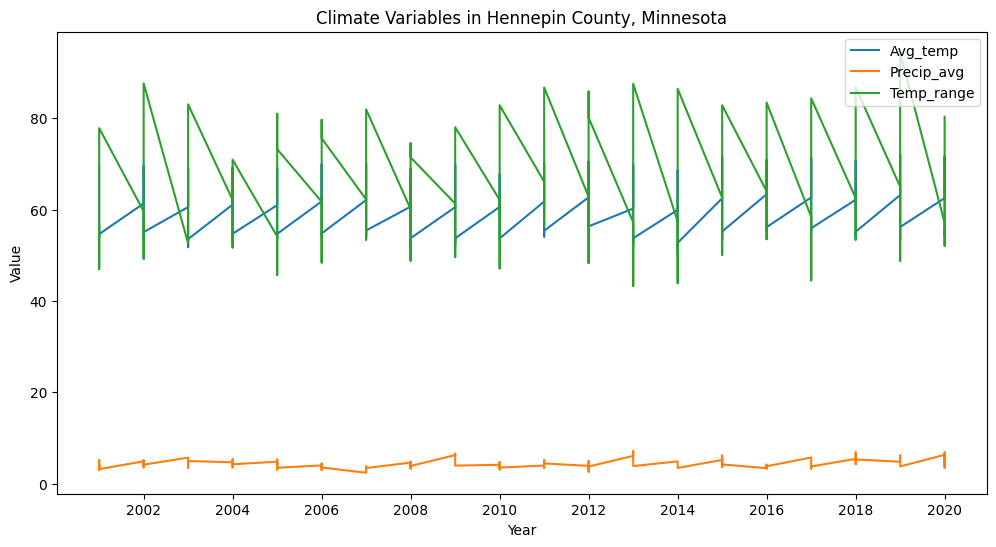

In [27]:
# Plot Lyme disease cases over time for a given state
plt.figure(figsize=(12, 6))
for county in minnesota_data['County Name'].unique():
    county_data = minnesota_data[minnesota_data['County Name'] == county]
    plt.plot(county_data['Year'], county_data['Cases'], label=county)
plt.title('Historical Lyme Disease Cases in Minnesota by County')
plt.xlabel('Year')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# Plot climate variables over time for a specific county (e.g., 'Hennepin')
hennepin_data = minnesota_data[minnesota_data['County Name'] == 'Clay County']
plt.figure(figsize=(12, 6))
plt.plot(hennepin_data['Year'], hennepin_data['Avg_temp'], label='Avg_temp')
plt.plot(hennepin_data['Year'], hennepin_data['Precip_avg'], label='Precip_avg')
plt.plot(hennepin_data['Year'], hennepin_data['Temp_range'], label='Temp_range')
plt.title('Climate Variables in Hennepin County, Minnesota')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()


In [4]:

# LSTM Model
# ~ 25% accurate
def preprocess_data(data, lag=1):
    data_lagged = data.copy()
    data_lagged['Avg_temp_lag'] = new_hampshire_data['Avg_temp'].shift(lag)
    data_lagged['Precip_avg_lag'] = new_hampshire_data['Precip_avg'].shift(lag)
    data_lagged['Temp_range_lag'] = new_hampshire_data['Temp_range'].shift(lag)
    data_lagged = data_lagged.dropna()
    
    features = ['Avg_temp_lag', 'Precip_avg_lag', 'Temp_range_lag']
    target = ['Cases']
    
    # Scale the features to ensure even distribution
    scaler = MinMaxScaler()
    data_lagged[features] = scaler.fit_transform(data_lagged[features])
    X = data_lagged[features].values
    y = data_lagged[target].values
    
    return X, y, scaler

data = new_hampshire_data  
data['Year'] = data['Year'].dt.year
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

X, y, scaler = preprocess_data(data)

# Split / Train / Test
train_size = int(len(X) * 2 / 3)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Train R²: {r2_train}")
print(f"Test R²: {r2_test}")

plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Cases')
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted Cases', linestyle='--')
plt.title('LSTM Model - Lyme Disease Cases Prediction (Test Set)')
plt.xlabel('Samples')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


NameError: name 'new_hampshire_data' is not defined

In [32]:
# Arimax Model
# Predictions for the next 5, 10 years

def forecast_arimax_with_climate(minnesota_data, selected_county=None):
    if selected_county:
        minnesota_data = minnesota_data[minnesota_data['County Name'] == selected_county]
    counties = minnesota_data['County Name'].unique()
    forecasts = {}

    for county in counties:
        county_data_county = minnesota_data[minnesota_data['County Name'] == county]
        X = county_data_county[['Avg_temp_lag1', 'Precip_avg_lag1', 'Temp_range_lag1']]
        y = county_data_county['Cases']
        
        model_arimax = ARIMA(y, exog=X, order=(1, 1, 1)) 
        model_arimax_fit = model_arimax.fit()

        # Forecast future Lyme disease cases (5, 10 years)
        forecast_5_cases = model_arimax_fit.forecast(steps=5, exog=X.tail(5))
        forecast_10_cases = model_arimax_fit.forecast(steps=10, exog=X.tail(10))

        forecast_5_climate = {}
        forecast_10_climate = {}

        for var in ['Avg_temp', 'Precip_avg', 'Temp_range']:
            model_climate = ARIMA(county_data_county[var], order=(1, 1, 1))  # You can adjust the order
            model_climate_fit = model_climate.fit()

            forecast_5_climate[var] = model_climate_fit.forecast(steps=5)
            forecast_10_climate[var] = model_climate_fit.forecast(steps=10)

        future_climate_5 = pd.DataFrame(forecast_5_climate)
        future_climate_10 = pd.DataFrame(forecast_10_climate)

        forecast_5_cases = model_arimax_fit.forecast(steps=5, exog=future_climate_5)
        forecast_10_cases = model_arimax_fit.forecast(steps=10, exog=future_climate_10)

        forecasts[county] = {
            '5-Year Forecast': {
                'Cases': forecast_5_cases,
                'Climate': forecast_5_climate
            },
            '10-Year Forecast': {
                'Cases': forecast_10_cases,
                'Climate': forecast_10_climate
            }
        }

    return forecasts

selected_county = 'Clay County' 
forecasts = forecast_arimax_with_climate(minnesota_data, selected_county)

print(forecasts)


{'Clay County': {'5-Year Forecast': {'Cases': 199   -0.050363
200   -0.046985
201   -0.046175
202   -0.045872
203   -0.045748
Name: predicted_mean, dtype: float64, 'Climate': {'Avg_temp': 199    58.184906
200    58.992207
201    59.252738
202    59.336815
203    59.363949
Name: predicted_mean, dtype: float64, 'Precip_avg': 199    4.899582
200    4.946421
201    4.964270
202    4.971072
203    4.973664
Name: predicted_mean, dtype: float64, 'Temp_range': 199    64.994962
200    63.839054
201    63.751755
202    63.745161
203    63.744663
Name: predicted_mean, dtype: float64}}, '10-Year Forecast': {'Cases': 199   -0.050363
200   -0.046985
201   -0.046175
202   -0.045872
203   -0.045748
204   -0.045697
205   -0.045677
206   -0.045668
207   -0.045665
208   -0.045664
Name: predicted_mean, dtype: float64, 'Climate': {'Avg_temp': 199    58.184906
200    58.992207
201    59.252738
202    59.336815
203    59.363949
204    59.372705
205    59.375531
206    59.376443
207    59.376737
208    59.376

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA par

Training and testing for county: Carroll County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
County: Carroll County
Train MAE: 16.63946292583759
Test MAE: 18.025945728521613
Train R²: 0.015656694078245326
Test R²: 0.0380367044516251


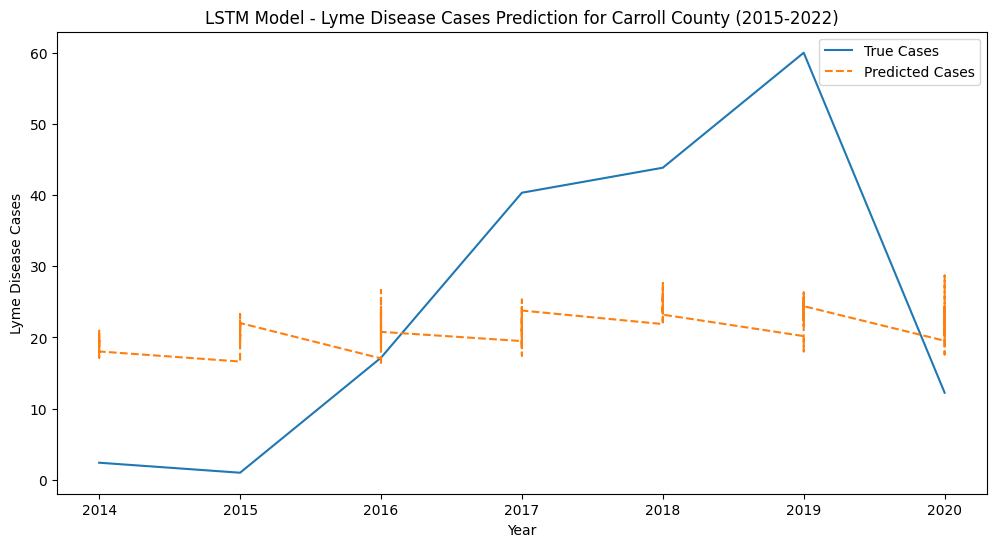

Training and testing for county: Sullivan County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
County: Sullivan County
Train MAE: 10.118436053395271
Test MAE: 10.553216607642895
Train R²: 0.017705245440983175
Test R²: -0.02930987401616081


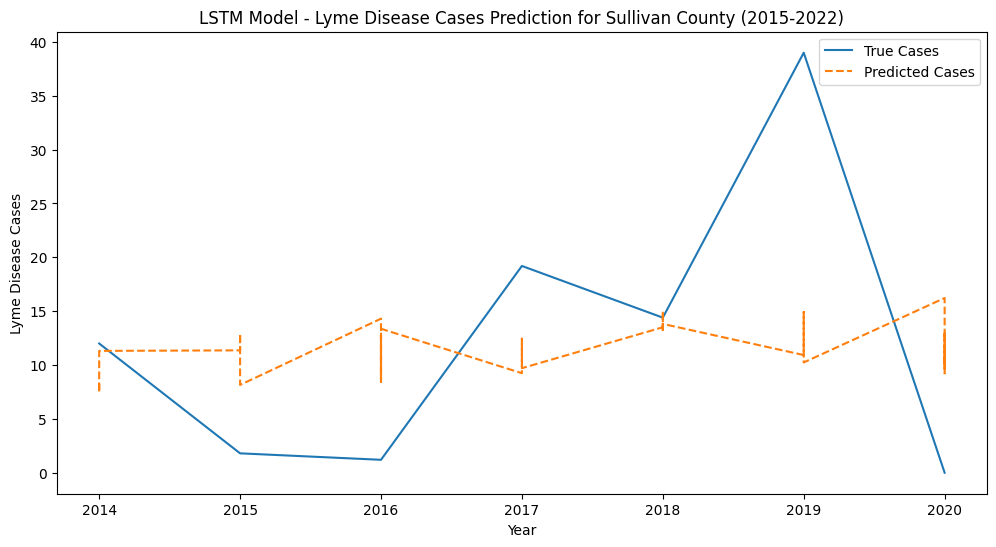

Training and testing for county: Hillsborough County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
County: Hillsborough County
Train MAE: 161.92478014075238
Test MAE: 171.6514943134354
Train R²: 0.03204387127953445
Test R²: 0.04248196186661579


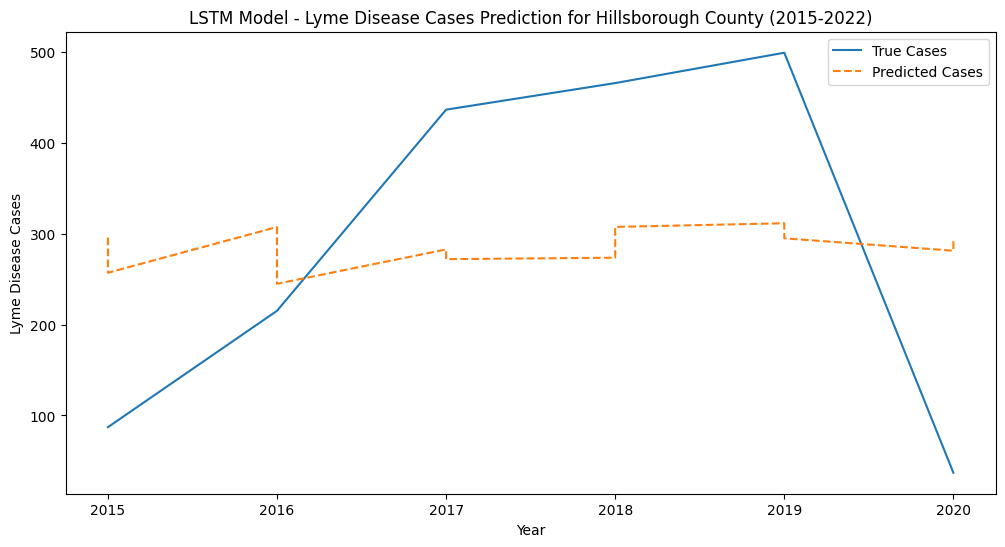

Training and testing for county: Rockingham County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
County: Rockingham County
Train MAE: 169.5305419921875
Test MAE: 185.65252010947782
Train R²: 0.022471110158973073
Test R²: -0.14810180714780197


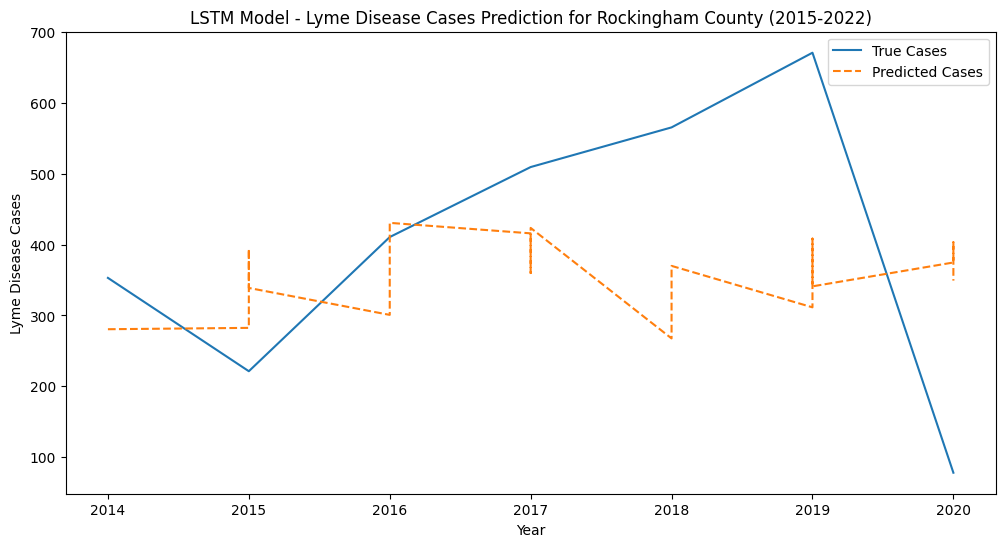

Training and testing for county: Coos County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
County: Coos County
Train MAE: 1.538987398147583
Test MAE: 3.1491905583275686
Train R²: 0.04291391650987242
Test R²: -0.6940371803767189


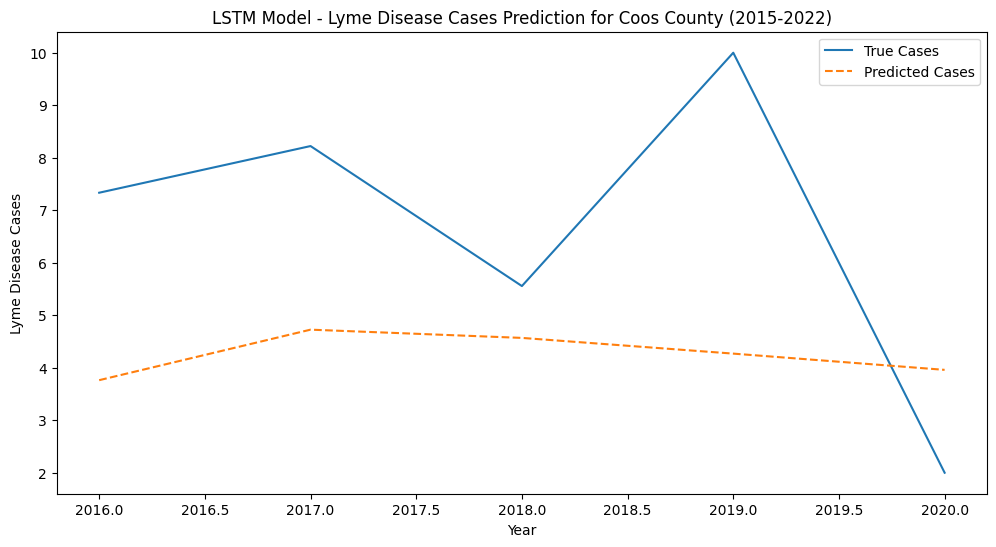

Training and testing for county: Belknap County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
County: Belknap County
Train MAE: 7.217582464218141
Test MAE: 8.701919923262162
Train R²: 0.39398158126394023
Test R²: 0.17874953034321528


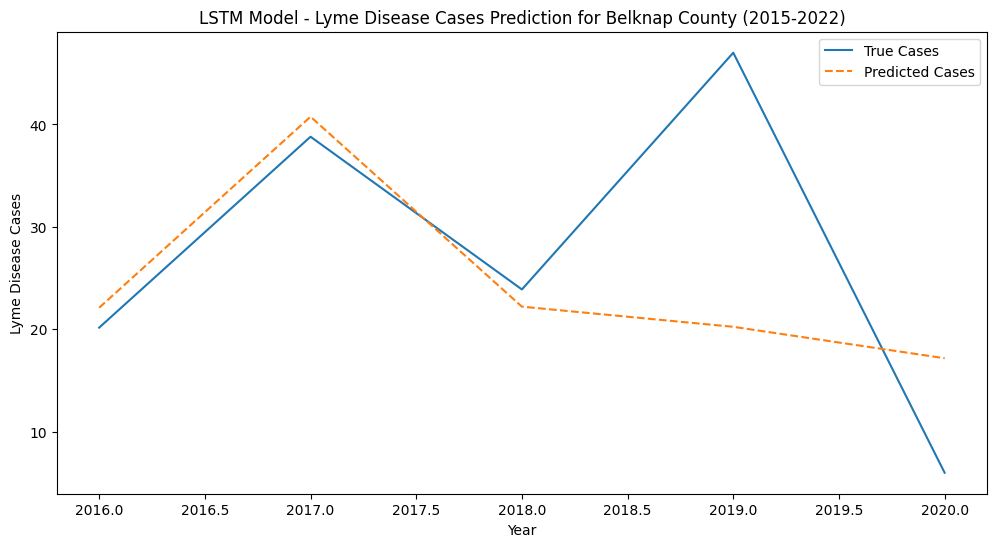

Training and testing for county: Cheshire County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
County: Cheshire County
Train MAE: 8.938782215118408
Test MAE: 15.799032277646273
Train R²: 0.44829283980357415
Test R²: 0.057193202613796235


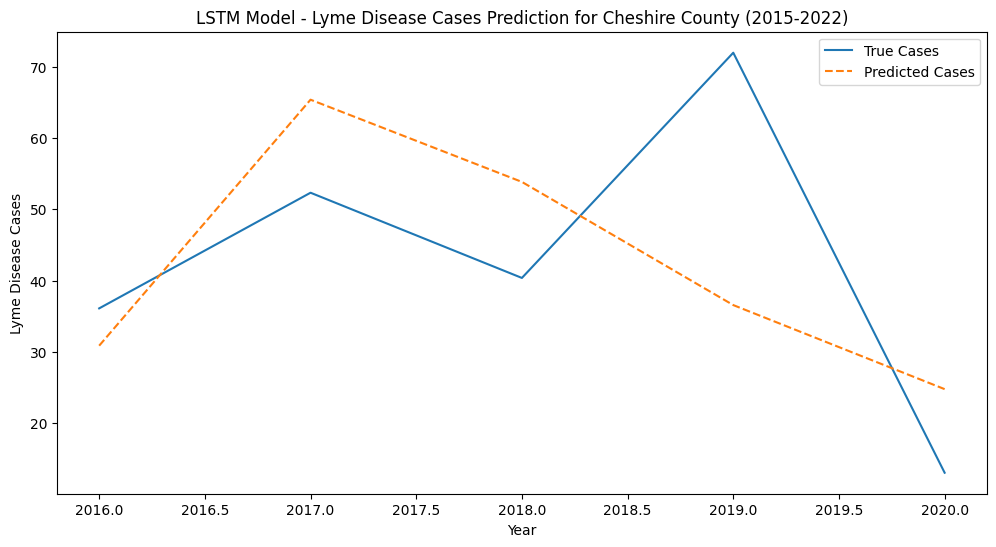

Training and testing for county: Grafton County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
County: Grafton County
Train MAE: 12.818192958831787
Test MAE: 17.972907667893633
Train R²: 0.4578341743552691
Test R²: -0.09311397700353741


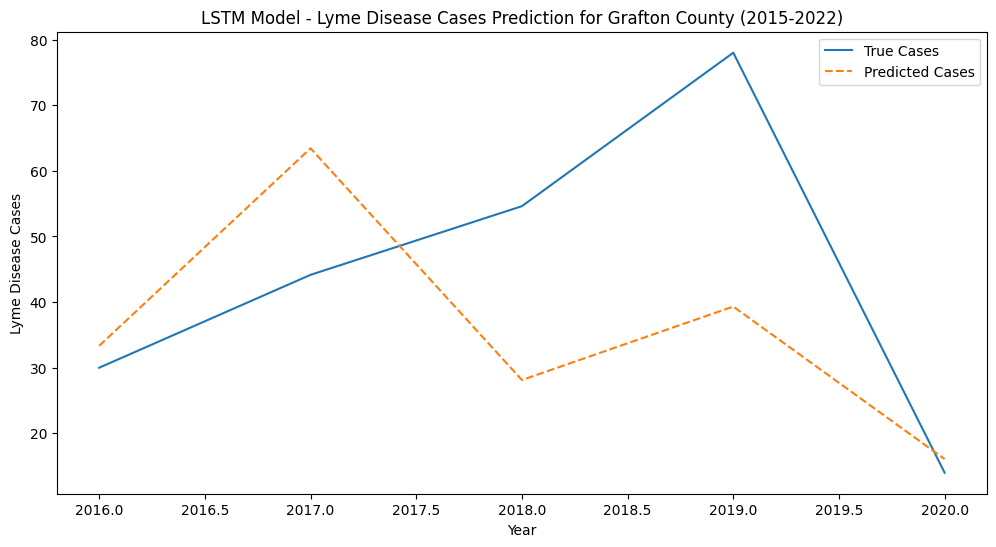

Training and testing for county: Merrimack County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
County: Merrimack County
Train MAE: 13.54926586151123
Test MAE: 37.39347742820273
Train R²: 0.6284304940212047
Test R²: -0.25435760283961484


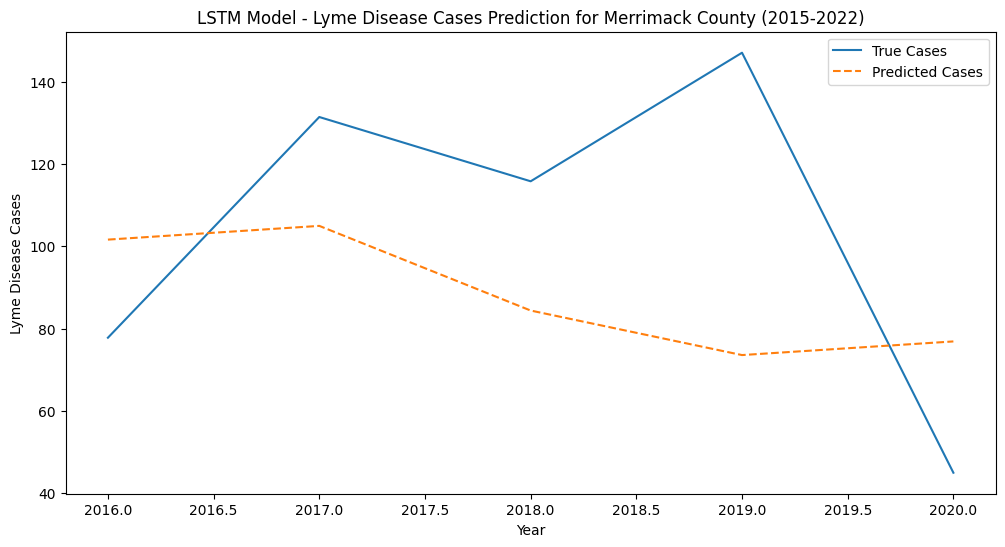

Training and testing for county: Strafford County


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
County: Strafford County
Train MAE: 34.49848747253418
Test MAE: 49.50492976262019
Train R²: 0.10686963897776869
Test R²: -0.047223794962561794


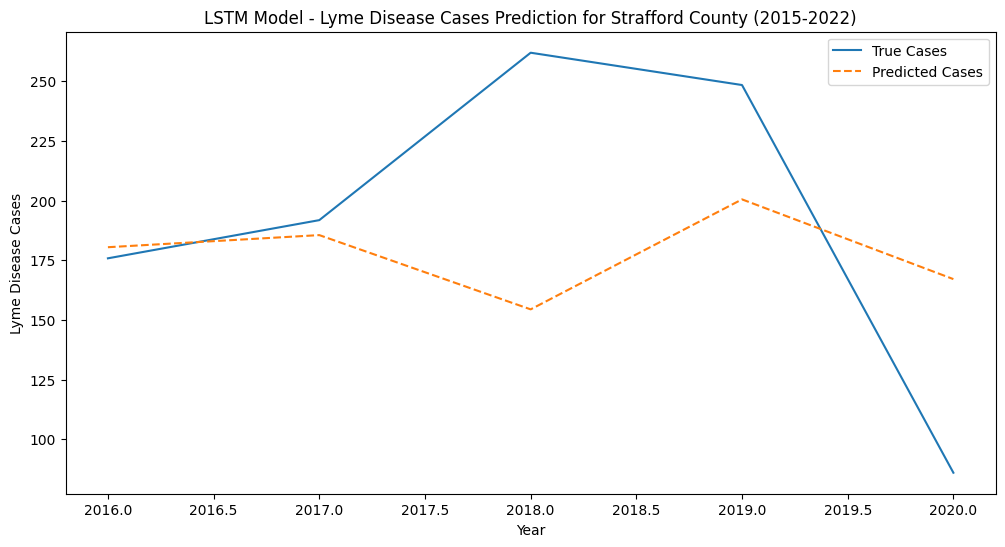

In [33]:
# Second LSTM model for each county within a state (really overfit)
# ~15% accurate but depends heavily on each county

def preprocess_data(data, lag=1):
    # Create lagged features
    data_lagged = data.copy()
    data_lagged['Avg_temp_lag'] = data['Avg_temp'].shift(lag)
    data_lagged['Precip_avg_lag'] = data['Precip_avg'].shift(lag)
    data_lagged['Temp_range_lag'] = data['Temp_range'].shift(lag)
    
    data_lagged = data_lagged.dropna()
    features = ['Avg_temp_lag', 'Precip_avg_lag', 'Temp_range_lag']
    target = ['Cases']
    
    scaler = MinMaxScaler()
    data_lagged[features] = scaler.fit_transform(data_lagged[features])
    y_scaler = MinMaxScaler()  # Separate scaler for target variable
    data_lagged[target] = y_scaler.fit_transform(data_lagged[target])
    
    X = data_lagged[features].values
    y = data_lagged[target].values
    
    return X, y, scaler, y_scaler, data_lagged

def split_data_temporal(data, train_ratio=0.66):
    data = data.sort_values(by='Year')
    split_index = int(len(data) * train_ratio)
    
    train_data = data[:split_index]
    test_data = data[split_index:]
    
    return train_data, test_data

def train_and_test_for_counties(data):
    counties = data['County Name'].unique()
    
    for county in counties:
        print(f'Training and testing for county: {county}')
        county_data = data[data['County Name'] == county]
        train_data, test_data = split_data_temporal(county_data)
        X_train, y_train, scaler, y_scaler, train_data_lagged = preprocess_data(train_data)
        X_test, y_test, _, _, test_data_lagged = preprocess_data(test_data)
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        model = Sequential()
        model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.1))
        model.add(LSTM(100))
        model.add(Dropout(0.1))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=100, batch_size=100, verbose=0)

        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        y_pred_train = y_scaler.inverse_transform(y_pred_train)
        y_pred_test = y_scaler.inverse_transform(y_pred_test)
        y_train = y_scaler.inverse_transform(y_train)
        y_test = y_scaler.inverse_transform(y_test)

        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print(f'County: {county}')
        print(f'Train MAE: {train_mae}')
        print(f'Test MAE: {test_mae}')
        print(f'Train R²: {train_r2}')
        print(f'Test R²: {test_r2}')
        
        plt.figure(figsize=(12, 6))
        plt.plot(test_data_lagged['Year'], y_test, label='True Cases')
        plt.plot(test_data_lagged['Year'], y_pred_test, label='Predicted Cases', linestyle='--')
        plt.title(f'LSTM Model - Lyme Disease Cases Prediction for {county} (2015-2022)')
        plt.xlabel('Year')
        plt.ylabel('Lyme Disease Cases')
        plt.legend()
        plt.show()

train_and_test_for_counties(new_hampshire_data)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Train MAE: 21.617895368696004
Test MAE: 199.16998827163525
Train R²: 0.8641287936331545
Test R²: -0.42835700558960976


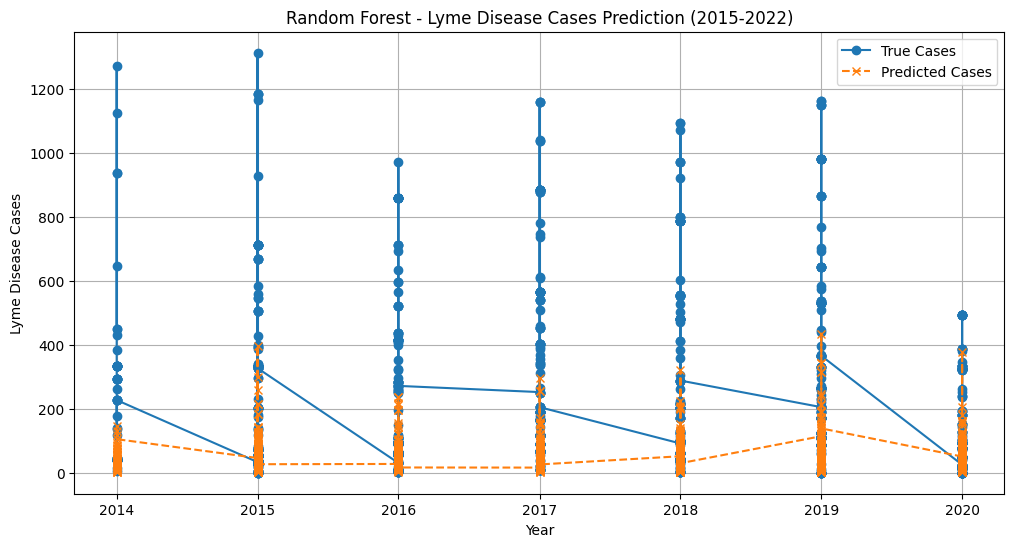

In [86]:


# Preprocess data (same as before)
def preprocess_data(northeast_data):
    features = ['Avg_temp', 'Precip_avg', 'Temp_range']
    target = ['Cases']

    # Scale the features and target
    scaler = MinMaxScaler()
    northeast_data[features] = scaler.fit_transform(northeast_data[features])
    y_scaler = MinMaxScaler()  # Separate scaler for target variable
    northeast_data[target] = y_scaler.fit_transform(northeast_data[target])

    X = northeast_data[features].values
    y = northeast_data[target].values

    return X, y, scaler, y_scaler

# Split the data into train and test sets based on years
def split_data_temporal(data, split_ratio=2/3):
    years = data['Year'].values
    # Sort the data by Year to ensure chronological order
    data_sorted = data.sort_values(by='Year')
    
    # Split the data by the split_ratio (2/3 training, 1/3 testing)
    split_index = int(len(data_sorted) * split_ratio)
    train_data = data_sorted[:split_index]
    test_data = data_sorted[split_index:]
    
    return train_data, test_data

# Split the data based on years (2/3 for training and 1/3 for testing)
train_data, test_data = split_data_temporal(northeast_data)

# Preprocess the data
X_train, y_train, scaler, y_scaler = preprocess_data(train_data)
X_test, y_test, _, _ = preprocess_data(test_data)

# Train a RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Inverse transform predictions
y_pred_train = y_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

# Calculate performance metrics
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train MAE: {train_mae}')
print(f'Test MAE: {test_mae}')
print(f'Train R²: {train_r2}')
print(f'Test R²: {test_r2}')

# Visualize the predictions
plt.figure(figsize=(12, 6))

# Ensure years and corresponding values are aligned for the plot
plt.plot(test_data['Year'], y_test, label='True Cases', marker='o')
plt.plot(test_data['Year'], y_pred_test, label='Predicted Cases', linestyle='--', marker='x')

plt.title('Random Forest - Lyme Disease Cases Prediction (2015-2022)')
plt.xlabel('Year')
plt.ylabel('Lyme Disease Cases')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 2s 399us/step - loss: 2413.4067
Epoch 2/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 2412.6536
Epoch 3/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 2414.7107
Epoch 4/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 2474.0906
Epoch 5/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 2488.6372
Epoch 6/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 2379.1450
Epoch 7/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 2564.7893
Epoch 8/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 2430.1472
Epoch 9/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 386us/step - loss: 2558.9275
Epoch 10/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 2632.0312
Epoch 11/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 2490.1357
Epoch 12/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 2252.5166
Epoch 13/100
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step - loss: 2538.2749
Epoch 14/100
3103/310

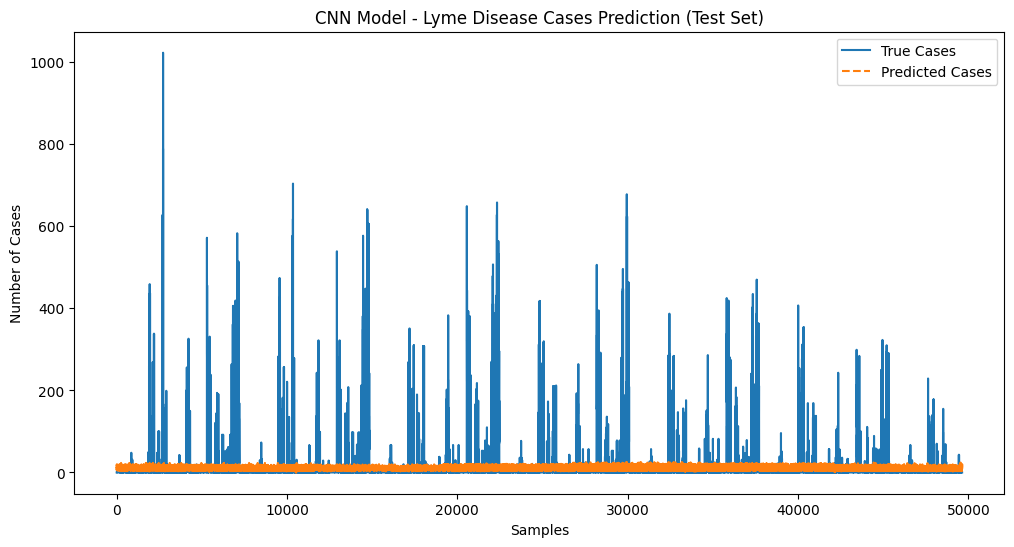

In [40]:
# CNN Model
# Not accurate

def preprocess_data(data, lag=1):
    data_lagged = data.copy()
    data_lagged['Avg_temp_lag'] = data['Avg_temp'].shift(lag)
    data_lagged['Precip_avg_lag'] = data['Precip_avg'].shift(lag)
    data_lagged['Temp_range_lag'] = data['Temp_range'].shift(lag)
    data_lagged = data_lagged.dropna()

    features = ['Avg_temp_lag', 'Precip_avg_lag', 'Temp_range_lag']
    target = ['Cases']
    scaler = MinMaxScaler()
    data_lagged[features] = scaler.fit_transform(data_lagged[features])
    X = data_lagged[features].values
    y = data_lagged[target].values
    
    return X, y, scaler

data = merged_data  
data = data.sort_values(by='Year')  

X, y, scaler = preprocess_data(data)

train_size = int(len(X) * 2 / 3)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be 3D for CNN: [samples, timesteps, features]
# We set timesteps = 1 (because we're predicting one step ahead) and features = 3 (lagged features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # 1 timestep, 3 features
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the CNN model
model = Sequential()
model.add(Input(shape=(1, X_train.shape[2])))  # Define the input shape explicitly (1 timestep, 3 features)

# Simplified CNN architecture: use 1D convolution with small kernel size
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))  # Kernel size 1 to avoid reducing sequence length
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))  # Output layer for regression (1 neuron for predicting future value)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Print the evaluation metrics
print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Train R²: {r2_train}")
print(f"Test R²: {r2_test}")

# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='True Cases')
plt.plot(range(len(y_pred_test)), y_pred_test, label='Predicted Cases', linestyle='--')
plt.title('CNN Model - Lyme Disease Cases Prediction (Test Set)')
plt.xlabel('Samples')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()